In [20]:
import lightgbm as lgb
import xgboost as xgb 
from sklearn.ensemble import RandomForestRegressor
import optuna.visualization as vis

import numpy as np
import optuna
import joblib
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib
import pickle

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

## By Country

### Data Loading

In [126]:
with open('../split_year_data/countries_dict.pkl', 'rb') as f:
    countries_dict_year = pickle.load(f)

In [127]:
with open('../split_income_models/countries_dict.pkl', 'rb') as f:
    countries_dict_inc = pickle.load(f)

In [128]:
filepath = '../fs_corr_income_data'

In [129]:
test_data_x60 = pd.read_csv(filepath + '/test/60/X_test.csv')
test_data_x60 = test_data_x60.drop(columns=['Unnamed: 0'], axis=1)
test_data_y60 = pd.read_csv(filepath + '/test/60/y_test.csv')
test_data_y60 = test_data_y60.drop(columns=['Unnamed: 0'], axis=1)

test_data_x70 = pd.read_csv(filepath + '/test/70/X_test.csv')
test_data_x70 = test_data_x70.drop(columns=['Unnamed: 0'], axis=1)
test_data_y70 = pd.read_csv(filepath + '/test/70/y_test.csv')
test_data_y70 = test_data_y70.drop(columns=['Unnamed: 0'], axis=1)

test_data_x80 = pd.read_csv(filepath + '/test/80/X_test.csv')
test_data_x80 = test_data_x80.drop(columns=['Unnamed: 0'], axis=1)
test_data_y80 = pd.read_csv(filepath + '/test/80/y_test.csv')
test_data_y80 = test_data_y80.drop(columns=['Unnamed: 0'], axis=1)

In [130]:
validation_60 = {}
validation_70 = {}
validation_80 = {}

for fold in range(0, 5):
    vdata_x60 = pd.read_csv(filepath + '/val/60/X_val_' + str(fold) + '.csv')
    vdata_x60 = vdata_x60.drop(columns=['Unnamed: 0'], axis=1)
    vdata_y60 = pd.read_csv(filepath + '/val/60/y_val_' + str(fold) + '.csv')
    vdata_y60 = vdata_y60.drop(columns=['Unnamed: 0'], axis=1)
    validation_60[fold] = [vdata_x60, vdata_y60]

    vdata_x70 = pd.read_csv(filepath + '/val/70/X_val_' + str(fold) + '.csv')
    vdata_x70 = vdata_x70.drop(columns=['Unnamed: 0'], axis=1)
    vdata_y70 = pd.read_csv(filepath + '/val/70/y_val_' + str(fold) + '.csv')
    vdata_y70 = vdata_y70.drop(columns=['Unnamed: 0'], axis=1)
    validation_70[fold] = [vdata_x70, vdata_y70]

    vdata_x80 = pd.read_csv(filepath + '/val/80/X_val_' + str(fold) + '.csv')
    vdata_x80 = vdata_x80.drop(columns=['Unnamed: 0'], axis=1)
    vdata_y80 = pd.read_csv(filepath + '/val/80/y_val_' + str(fold) + '.csv')
    vdata_y80 = vdata_y80.drop(columns=['Unnamed: 0'], axis=1)
    validation_80[fold] = [vdata_x80, vdata_y80]

In [131]:
train_60 = {}
train_70 = {}
train_80 = {}

for corr_idx, corr in enumerate(['60', '70', '80']):
    for fold in range(0, 5):
        tdata_x85 = pd.read_csv(filepath + '/train/' + corr + '/X_train_' + str(fold) + '_85.csv')
        tdata_x85 = tdata_x85.drop(columns=['Unnamed: 0'], axis=1)
        tdata_y85 = pd.read_csv(filepath + '/train/' + corr + '/y_train_' + str(fold) + '_85.csv')
        tdata_y85 = tdata_y85.drop(columns=['Unnamed: 0'], axis=1)

        tdata_x95 = pd.read_csv(filepath + '/train/' + corr + '/X_train_' + str(fold) + '_95.csv')
        tdata_x95 = tdata_x95.drop(columns=['Unnamed: 0'], axis=1)
        tdata_y95 = pd.read_csv(filepath + '/train/' + corr + '/y_train_' + str(fold) + '_95.csv')
        tdata_y95 = tdata_y95.drop(columns=['Unnamed: 0'], axis=1)

        tdata_x1 = pd.read_csv(filepath + '/train/' + corr + '/X_train_' + str(fold) + '_1.csv')
        tdata_x1 = tdata_x1.drop(columns=['Unnamed: 0'], axis=1)
        tdata_y1 = pd.read_csv(filepath + '/train/' + corr + '/y_train_' + str(fold) + '_1.csv')
        tdata_y1 = tdata_y1.drop(columns=['Unnamed: 0'], axis=1)

        if corr_idx == 0:
            train_60[fold] = [tdata_x85, tdata_y85, tdata_x95, tdata_y95, tdata_x1, tdata_y1]
        if corr_idx == 1:
            train_70[fold] = [tdata_x85, tdata_y85, tdata_x95, tdata_y95, tdata_x1, tdata_y1]
        else: train_80[fold] = [tdata_x85, tdata_y85, tdata_x95, tdata_y95, tdata_x1, tdata_y1]

In [132]:
filepath_lit = '../fs_fromlit_data'
test_data_x_lit_inc = pd.read_csv(filepath_lit + '/income/test/X_test.csv')
test_data_x_lit_inc = test_data_x_lit_inc.drop(columns=['Unnamed: 0'], axis=1)
test_data_y_lit_inc = pd.read_csv(filepath_lit + '/income/test/y_test.csv')
test_data_y_lit_inc = test_data_y_lit_inc.drop(columns=['Unnamed: 0'], axis=1)
test_data_lit_inc = pd.concat([test_data_x_lit_inc, test_data_y_lit_inc])

test_data_x_lit_year = pd.read_csv(filepath_lit + '/year/test/X_test.csv')
test_data_x_lit_year = test_data_x_lit_year.drop(columns=['Unnamed: 0'], axis=1)
test_data_y_lit_year = pd.read_csv(filepath_lit + '/year/test/y_test.csv')
test_data_y_lit_year = test_data_y_lit_year.drop(columns=['Unnamed: 0'], axis=1)
test_data_lit_year = pd.concat([test_data_x_lit_year, test_data_y_lit_year])

In [133]:
validation_lit_inc = {}
validation_lit_year = {}

for fold in range(0, 5):
    vdata_xinc = pd.read_csv(filepath_lit + '/income/val/X_val_' + str(fold) + '.csv')
    vdata_xinc = vdata_xinc.drop(columns=['Unnamed: 0'], axis=1)
    vdata_yinc = pd.read_csv(filepath_lit + '/income/val/y_val_' + str(fold) + '.csv')
    vdata_yinc = vdata_yinc.drop(columns=['Unnamed: 0'], axis=1)
    validation_lit_inc[fold] = [vdata_xinc, vdata_yinc]

    vdata_xyear = pd.read_csv(filepath_lit + '/year/val/X_val_' + str(fold) + '.csv')
    vdata_xyear = vdata_xyear.drop(columns=['Unnamed: 0'], axis=1)
    vdata_yyear = pd.read_csv(filepath_lit + '/year/val/y_val_' + str(fold) + '.csv')
    vdata_yyear = vdata_yyear.drop(columns=['Unnamed: 0'], axis=1)
    validation_lit_year[fold] = [vdata_xyear, vdata_yyear]

In [134]:
train_lit_inc = {}
train_lit_year = {}

for fold in range(0, 5):
        tdata_x85inc = pd.read_csv(filepath_lit + '/income/train/X_train_' + str(fold) + '_85.csv')
        tdata_x85inc = tdata_x85inc.drop(columns=['Unnamed: 0'], axis=1)
        tdata_y85inc = pd.read_csv(filepath_lit + '/income/train/y_train_' + str(fold) + '_85.csv')
        tdata_y85inc = tdata_y85inc.drop(columns=['Unnamed: 0'], axis=1)

        tdata_x95inc = pd.read_csv(filepath_lit + '/income/train/X_train_' + str(fold) + '_95.csv')
        tdata_x95inc = tdata_x95inc.drop(columns=['Unnamed: 0'], axis=1)
        tdata_y95inc = pd.read_csv(filepath_lit + '/income/train/y_train_' + str(fold) + '_95.csv')
        tdata_y95inc = tdata_y95inc.drop(columns=['Unnamed: 0'], axis=1)

        tdata_x1inc= pd.read_csv(filepath_lit + '/income/train/X_train_' + str(fold) + '_1.csv')
        tdata_x1inc= tdata_x1inc.drop(columns=['Unnamed: 0'], axis=1)
        tdata_y1inc= pd.read_csv(filepath_lit + '/income/train/y_train_' + str(fold) + '_1.csv')
        tdata_y1inc= tdata_y1inc.drop(columns=['Unnamed: 0'], axis=1)

        train_lit_inc[fold] = [tdata_x85inc, tdata_y85inc, tdata_x95inc, tdata_y95inc, tdata_x1inc, tdata_y1inc]

        tdata_x85year = pd.read_csv(filepath_lit + '/year/train/X_train_' + str(fold) + '_85.csv')
        tdata_x85year = tdata_x85year.drop(columns=['Unnamed: 0'], axis=1)
        tdata_y85year = pd.read_csv(filepath_lit + '/year/train/y_train_' + str(fold) + '_85.csv')
        tdata_y85year = tdata_y85year.drop(columns=['Unnamed: 0'], axis=1)

        tdata_x95year = pd.read_csv(filepath_lit + '/year/train/X_train_' + str(fold) + '_95.csv')
        tdata_x95year = tdata_x95year.drop(columns=['Unnamed: 0'], axis=1)
        tdata_y95year = pd.read_csv(filepath_lit + '/year/train/y_train_' + str(fold) + '_95.csv')
        tdata_y95year = tdata_y95year.drop(columns=['Unnamed: 0'], axis=1)

        tdata_x1year= pd.read_csv(filepath_lit + '/year/train/X_train_' + str(fold) + '_1.csv')
        tdata_x1year= tdata_x1year.drop(columns=['Unnamed: 0'], axis=1)
        tdata_y1year= pd.read_csv(filepath_lit + '/year/train/y_train_' + str(fold) + '_1.csv')
        tdata_y1year= tdata_y1year.drop(columns=['Unnamed: 0'], axis=1)

        train_lit_year[fold] = [tdata_x85year, tdata_y85year, tdata_x95year, tdata_y95year, tdata_x1year, tdata_y1year]

### Gathering Test Values

In [135]:
# setting up the dataframe to hold test results
index = pd.MultiIndex.from_tuples(
    [('Correlation 0.6', 'Threshold 85%', '1'), ('Correlation 0.6', 'Threshold 85%', '2'), ('Correlation 0.6', 'Threshold 85%', '3'), 
     ('Correlation 0.6', 'Threshold 85%', '4'), ('Correlation 0.6', 'Threshold 85%', '5'), ('Correlation 0.6', 'Threshold 95%', '1'), 
     ('Correlation 0.6', 'Threshold 95%', '2'), ('Correlation 0.6', 'Threshold 95%', '3'), ('Correlation 0.6', 'Threshold 95%', '4'), 
     ('Correlation 0.6', 'Threshold 95%', '5'), ('Correlation 0.6', 'None', '1'), ('Correlation 0.6', 'None', '2'), 
     ('Correlation 0.6', 'None', '3'), ('Correlation 0.6', 'None', '4'), ('Correlation 0.6', 'None', '5'), ('Correlation 0.7', 'Threshold 85%', '1'), 
     ('Correlation 0.7', 'Threshold 85%', '2'), ('Correlation 0.7', 'Threshold 85%', '3'), 
     ('Correlation 0.7', 'Threshold 85%', '4'), ('Correlation 0.7', 'Threshold 85%', '5'), ('Correlation 0.7', 'Threshold 95%', '1'), 
     ('Correlation 0.7', 'Threshold 95%', '2'), ('Correlation 0.7', 'Threshold 95%', '3'), ('Correlation 0.7', 'Threshold 95%', '4'), 
     ('Correlation 0.7', 'Threshold 95%', '5'), ('Correlation 0.7', 'None', '1'), ('Correlation 0.7', 'None', '2'), 
     ('Correlation 0.7', 'None', '3'), ('Correlation 0.7', 'None', '4'), ('Correlation 0.7', 'None', '5'), ('Correlation 0.8', 'Threshold 85%', '1'), 
     ('Correlation 0.8', 'Threshold 85%', '2'), ('Correlation 0.8', 'Threshold 85%', '3'), 
     ('Correlation 0.8', 'Threshold 85%', '4'), ('Correlation 0.8', 'Threshold 85%', '5'), ('Correlation 0.8', 'Threshold 95%', '1'), 
     ('Correlation 0.8', 'Threshold 95%', '2'), ('Correlation 0.8', 'Threshold 95%', '3'), ('Correlation 0.8', 'Threshold 95%', '4'), 
     ('Correlation 0.8', 'Threshold 95%', '5'), ('Correlation 0.8', 'None', '1'), ('Correlation 0.8', 'None', '2'), 
     ('Correlation 0.8', 'None', '3'), ('Correlation 0.8', 'None', '4'), ('Correlation 0.8', 'None', '5'), ('Correlation Lit', 'Threshold 85%', '1'), 
     ('Correlation Lit', 'Threshold 85%', '2'), ('Correlation Lit', 'Threshold 85%', '3'), 
     ('Correlation Lit', 'Threshold 85%', '4'), ('Correlation Lit', 'Threshold 85%', '5'), ('Correlation Lit', 'Threshold 95%', '1'), 
     ('Correlation Lit', 'Threshold 95%', '2'), ('Correlation Lit', 'Threshold 95%', '3'), ('Correlation Lit', 'Threshold 95%', '4'), 
     ('Correlation Lit', 'Threshold 95%', '5'), ('Correlation Lit', 'None', '1'), ('Correlation Lit', 'None', '2'), 
     ('Correlation Lit', 'None', '3'), ('Correlation Lit', 'None', '4'), ('Correlation Lit', 'None', '5')],
    names=['Correlation Subset', 'Missing Data Threshold', 'Fold']
)
test_stats_corr_rf = pd.DataFrame(index=index, columns=['MAPE', 'MAE', 'MSE', 'RMSE', 'R2'])
test_stats_corr_xgb = pd.DataFrame(index=index, columns=['MAPE', 'MAE', 'MSE', 'RMSE', 'R2'])
test_stats_corr_lgb = pd.DataFrame(index=index, columns=['MAPE', 'MAE', 'MSE', 'RMSE', 'R2'])

In [136]:
output_dir_lgb = '../feature_selection_models/by_country/lightgbm'
output_dir_lgb_lit = '../fs_fromlit_models/income/lightgbm'

In [137]:
for corr_idx, corr in enumerate(['60', '70', '80', 'lit']):
    testing_datax = None
    testing_datay = None
    training_data = None
    if corr_idx == 0:
        testing_datax = test_data_x60.copy()
        testing_datay = test_data_y60.copy()
        training_data = train_60
    elif corr_idx == 1:
        testing_datax = test_data_x70.copy()
        testing_datay = test_data_y70.copy()
        training_data = train_70
    elif corr_idx == 2:
        testing_datax = test_data_x80.copy()
        testing_datay = test_data_y80.copy()
        training_data = train_80
    elif corr_idx == 3:
        testing_datax = test_data_x_lit_inc.copy()
        testing_datay = test_data_y_lit_inc.copy()
        training_data = train_lit_inc
    
    testing_datax.columns = testing_datax.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)
    testing_datay.column = 'Maternal mortality ratio (national estimate per 100000 live births)'

    corr_name = ''
    table_corr_name = ''
    if corr_idx == 0:
        corr_name = 'corr_60'
        table_corr_name = 'Correlation 0.6'
    elif corr_idx == 1:
        corr_name = 'corr_70'
        table_corr_name = 'Correlation 0.7'
    elif corr_idx == 2: 
        corr_name = 'corr_80'
        table_corr_name = 'Correlation 0.8'
    elif corr_idx == 3: 
        table_corr_name = 'Correlation Lit'

    for fold, fold_num in enumerate(['1', '2', '3', '4', '5']):
        for thresh, thresh_name in enumerate(['Threshold 85%', 'Threshold 95%', 'None']):
            if fold == 0 and thresh_name == 'Threshold 85%' and corr_name == 'corr_80':
                continue

            if thresh == 0:
                name = '85'
            elif thresh == 1:
                name = '95'
            else: name = '1'

            if corr_idx !=3 :
                best_params = joblib.load(f"{output_dir_lgb}/best_params_{corr_name}_{fold}_{name}.pkl")
            else:
                best_params = joblib.load(f"{output_dir_lgb_lit}/best_params_{fold}_{name}.pkl")

            train_input_data = training_data[fold][thresh * 2].copy()
            train_input_data.columns = train_input_data.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)

            train_label = training_data[fold][thresh * 2 + 1].copy()
            train_label.column = 'Maternal mortality ratio (national estimate per 100000 live births)'

            to_test = testing_datax[train_input_data.columns].copy()

            if corr_idx == 3:
                train_input_data['setting'] = train_input_data['setting'].astype("category")
                to_test['setting'] = to_test['setting'].astype("category")

            loaded_model = lgb.LGBMRegressor(**best_params, verbosity = -1)
            train_load = loaded_model.fit(train_input_data, train_label)
            prediction = train_load.predict(to_test)
            mse = mean_squared_error(prediction, testing_datay)
            mae = mean_absolute_error(prediction, testing_datay)
            rmse = np.sqrt(mse)
            r2 = r2_score(prediction, testing_datay)

            #to calculate mape
            num_predictions = len(prediction)
            mape = 0
            for p in range(0, num_predictions):
                mape += np.abs(prediction[p] - testing_datay.iloc[p]) / np.maximum(np.abs(prediction[p]), np.abs(testing_datay.iloc[p]))
            mape = mape/num_predictions

            test_stats_corr_lgb.loc[(table_corr_name, thresh_name, fold_num), 'MSE'] = mse
            test_stats_corr_lgb.loc[(table_corr_name, thresh_name, fold_num), 'MAE'] = mae
            test_stats_corr_lgb.loc[(table_corr_name, thresh_name, fold_num), 'RMSE'] = rmse
            test_stats_corr_lgb.loc[(table_corr_name, thresh_name, fold_num), 'R2'] = r2
            test_stats_corr_lgb.loc[(table_corr_name, thresh_name, fold_num), 'MAPE'] = mape[0]

/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_5589/496013568.py:86: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_stats_corr_lgb.loc[(table_corr_name, thresh_name, fold_num), 'MAPE'] = mape[0]
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_5589/496013568.py:86: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_stats_corr_lgb.loc[(table_corr_name, thresh_name, fold_num), 'MAPE'] = mape[0]
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_5589/496013568.py:86: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always

In [138]:
output_dir_xgb = '../feature_selection_models/by_country/xgboost'
output_dir_xgb_lit = '../fs_fromlit_models/income/xgboost'

In [139]:
for corr_idx, corr in enumerate(['60', '70', '80', 'lit']):
    testing_datax = None
    testing_datay = None
    training_data = None
    if corr_idx == 0:
        testing_datax = test_data_x60.copy()
        testing_datay = test_data_y60.copy()
        training_data = train_60
    elif corr_idx == 1:
        testing_datax = test_data_x70.copy()
        testing_datay = test_data_y70.copy()
        training_data = train_70
    elif corr_idx == 2:
        testing_datax = test_data_x80.copy()
        testing_datay = test_data_y80.copy()
        training_data = train_80
    elif corr_idx == 3:
        testing_datax = test_data_x_lit_inc.copy()
        testing_datay = test_data_y_lit_inc.copy()
        training_data = train_lit_inc
    
    corr_name = ''
    table_corr_name = ''
    if corr_idx == 0:
        corr_name = 'corr_60'
        table_corr_name = 'Correlation 0.6'
    elif corr_idx == 1:
        corr_name = 'corr_70'
        table_corr_name = 'Correlation 0.7'
    elif corr_idx == 2: 
        corr_name = 'corr_80'
        table_corr_name = 'Correlation 0.8'
    elif corr_idx == 3: 
        table_corr_name = 'Correlation Lit'

    for fold, fold_num in enumerate(['1', '2', '3', '4', '5']):
        for thresh, thresh_name in enumerate(['Threshold 85%', 'Threshold 95%', 'None']):
            if fold == 0 and thresh_name == 'Threshold 85%' and corr_name == 'corr_80':
                continue

            if thresh == 0:
                name = '85'
            elif thresh == 1:
                name = '95'
            else: name = '1'

            if corr_idx !=3 :
                bp = joblib.load(f"{output_dir_xgb}/best_params_{corr_name}_{fold}_{name}.pkl")
            else:
                bp = joblib.load(f"{output_dir_xgb_lit}/best_params_{fold}_{name}.pkl")
                
            
            best_params = {'n_estimators' : bp['number_trees'], 'max_depth' : bp['max_tree_depth'], 'booster' : bp['boosting_type'], 'reg_alpha' : bp['l1_norm'], 
            'reg_lambda' : bp['l2_norm'], 'subsample' : bp['subsample'], 'learning_rate' : bp['learning_rate']}

            train_input_data = training_data[fold][thresh * 2].copy()

            train_label = training_data[fold][thresh * 2 + 1].copy()

            to_test = testing_datax[train_input_data.columns].copy()

            if corr_idx == 3:
                train_input_data['setting'] = train_input_data['setting'].astype("category")
                to_test['setting'] = to_test['setting'].astype("category")

            loaded_model = xgb.XGBRegressor(**best_params, enable_categorical=True)
            train_load = loaded_model.fit(train_input_data, train_label)
            prediction = train_load.predict(to_test)
            mse = mean_squared_error(prediction, testing_datay)
            mae = mean_absolute_error(prediction, testing_datay)
            rmse = np.sqrt(mse)
            r2 = r2_score(prediction, testing_datay)

            #to calculate mape
            num_predictions = len(prediction)
            mape = 0
            for p in range(0, num_predictions):
                mape += np.abs(prediction[p] - testing_datay.iloc[p]) / np.maximum(np.abs(prediction[p]), np.abs(testing_datay.iloc[p]))
            mape = mape/num_predictions

            test_stats_corr_xgb.loc[(table_corr_name, thresh_name, fold_num), 'MSE'] = mse
            test_stats_corr_xgb.loc[(table_corr_name, thresh_name, fold_num), 'MAE'] = mae
            test_stats_corr_xgb.loc[(table_corr_name, thresh_name, fold_num), 'RMSE'] = rmse
            test_stats_corr_xgb.loc[(table_corr_name, thresh_name, fold_num), 'R2'] = r2
            test_stats_corr_xgb.loc[(table_corr_name, thresh_name, fold_num), 'MAPE'] = mape[0]

/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_5589/1032911040.py:85: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_stats_corr_xgb.loc[(table_corr_name, thresh_name, fold_num), 'MAPE'] = mape[0]
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_5589/1032911040.py:85: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_stats_corr_xgb.loc[(table_corr_name, thresh_name, fold_num), 'MAPE'] = mape[0]
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_5589/1032911040.py:85: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will alw

In [140]:
output_dir_rf = '../feature_selection_models/by_country/random_forest'
output_dir_rf_lit = '../fs_fromlit_models/income/rf'

In [141]:
for corr_idx, corr in enumerate(['60', '70', '80', 'lit']):
    testing_datax = None
    testing_datay = None
    training_data = None
    if corr_idx == 0:
        testing_datax = test_data_x60.copy()
        testing_datay = test_data_y60.copy()
        training_data = train_60
    elif corr_idx == 1:
        testing_datax = test_data_x70.copy()
        testing_datay = test_data_y70.copy()
        training_data = train_70
    elif corr_idx == 2:
        testing_datax = test_data_x80.copy()
        testing_datay = test_data_y80.copy()
        training_data = train_80
    elif corr_idx == 3:
        testing_datax = test_data_x_lit_inc.copy()
        testing_datay = test_data_y_lit_inc.copy()
        training_data = train_lit_inc
    
    corr_name = ''
    table_corr_name = ''
    if corr_idx == 0:
        corr_name = 'corr_60'
        table_corr_name = 'Correlation 0.6'
    elif corr_idx == 1:
        corr_name = 'corr_70'
        table_corr_name = 'Correlation 0.7'
    elif corr_idx == 2: 
        corr_name = 'corr_80'
        table_corr_name = 'Correlation 0.8'
    elif corr_idx == 3: 
        table_corr_name = 'Correlation Lit'

    for fold, fold_num in enumerate(['1', '2', '3', '4', '5']):
        for thresh, thresh_name in enumerate(['Threshold 85%', 'Threshold 95%', 'None']):
            if fold == 0 and thresh_name == 'Threshold 85%' and corr_name == 'corr_80':
                continue

            if thresh == 0:
                name = '85'
            elif thresh == 1:
                name = '95'
            else: name = '1'

            if corr_idx != 3:
                best_params = joblib.load(f"{output_dir_rf}/best_params_{corr_name}_{fold}_{name}.pkl")
            else:
                best_params = joblib.load(f"{output_dir_rf_lit}/best_params_{fold}_{name}.pkl")

            train_input_data = training_data[fold][thresh * 2].copy()

            train_label = training_data[fold][thresh * 2 + 1].copy()

            to_test = testing_datax[train_input_data.columns].copy()

            if corr_idx == 3:
                train_input_data['setting'] = train_input_data['setting'].map(countries_dict_inc)
                train_input_data['setting'] = train_input_data['setting'].astype("category")
                to_test['setting'] = to_test['setting'].map(countries_dict_inc)
                to_test['setting'] = to_test['setting'].astype("category")

            loaded_model = RandomForestRegressor(**best_params)
            train_load = loaded_model.fit(train_input_data, train_label)
            prediction = train_load.predict(to_test)
            mse = mean_squared_error(prediction, testing_datay)
            mae = mean_absolute_error(prediction, testing_datay)
            rmse = np.sqrt(mse)
            r2 = r2_score(prediction, testing_datay)

            #to calculate mape
            num_predictions = len(prediction)
            mape = 0
            for p in range(0, num_predictions):
                mape += np.abs(prediction[p] - testing_datay.iloc[p]) / np.maximum(np.abs(prediction[p]), np.abs(testing_datay.iloc[p]))
            mape = mape/num_predictions

            test_stats_corr_rf.loc[(table_corr_name, thresh_name, fold_num), 'MSE'] = mse
            test_stats_corr_rf.loc[(table_corr_name, thresh_name, fold_num), 'MAE'] = mae
            test_stats_corr_rf.loc[(table_corr_name, thresh_name, fold_num), 'RMSE'] = rmse
            test_stats_corr_rf.loc[(table_corr_name, thresh_name, fold_num), 'R2'] = r2
            test_stats_corr_rf.loc[(table_corr_name, thresh_name, fold_num), 'MAPE'] = mape[0]

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_5589/1526619408.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_stats_corr_rf.loc[(table_corr_name, thresh_name, fold_num), 'MAPE'] = mape[0]
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_5589

In [142]:
mean_summary_lgb = test_stats_corr_lgb.groupby(['Correlation Subset', 'Missing Data Threshold']).mean()
mean_summary_lgb = mean_summary_lgb.astype('float')
mean_summary_lgb = mean_summary_lgb.round(2)
std_summary_lgb = test_stats_corr_lgb.groupby(['Correlation Subset', 'Missing Data Threshold']).std()
std_summary_lgb = std_summary_lgb.astype('float')
std_summary_lgb = std_summary_lgb.round(2)

In [143]:
mean_summary_xgb = test_stats_corr_xgb.groupby(['Correlation Subset', 'Missing Data Threshold']).mean()
mean_summary_xgb = mean_summary_xgb.astype('float')
mean_summary_xgb = mean_summary_xgb.round(2)
std_summary_xgb = test_stats_corr_xgb.groupby(['Correlation Subset', 'Missing Data Threshold']).std()
std_summary_xgb = std_summary_xgb.astype('float')
std_summary_xgb = std_summary_xgb.round(2)

In [144]:
mean_summary_rf = test_stats_corr_rf.groupby(['Correlation Subset', 'Missing Data Threshold']).mean()
mean_summary_rf = mean_summary_rf.astype('float')
mean_summary_rf = mean_summary_rf.round(2)
std_summary_rf = test_stats_corr_rf.groupby(['Correlation Subset', 'Missing Data Threshold']).std()
std_summary_rf = std_summary_rf.astype('float')
std_summary_rf = std_summary_rf.round(2)

### Visualisation

In [183]:
result_dict_inc_lgb = {}
result_dict_inc_xgb = {}
result_dict_inc_rf = {}

# Loop through each metric and compute the max % fold difference
for metric in ['MAPE', 'MSE', 'MAE']:
    result = test_stats_corr_lgb.groupby(['Correlation Subset', 'Missing Data Threshold'])[metric].agg(
        lambda x: ((x.max() - x.min()) / x.mean()) * 100
    )
    result_dict_inc_lgb[metric] = result

    result = test_stats_corr_xgb.groupby(['Correlation Subset', 'Missing Data Threshold'])[metric].agg(
        lambda x: ((x.max() - x.min()) / x.mean()) * 100
    )
    result_dict_inc_xgb[metric] = result

    result = test_stats_corr_rf.groupby(['Correlation Subset', 'Missing Data Threshold'])[metric].agg(
        lambda x: ((x.max() - x.min()) / x.mean()) * 100
    )
    result_dict_inc_rf[metric] = result

In [184]:
print('LightGBM')
pd.DataFrame(result_dict_inc_lgb)

LightGBM


MAPE        MSE        MAE
Correlation Subset Missing Data Threshold                                 
Correlation 0.6    None                    12.126100  21.868719   8.942112
                   Threshold 85%           25.936225  21.059575  13.383453
                   Threshold 95%           19.375830  17.194446  14.049768
Correlation 0.7    None                    20.860158  33.558374  19.968570
                   Threshold 85%           21.007996  27.917460  19.493706
                   Threshold 95%           19.042825   8.100825  19.805024
Correlation 0.8    None                     4.166647  12.868323  11.818626
                   Threshold 85%            4.179732   8.427123   6.866301
                   Threshold 95%            7.678677  26.827391  20.967280
Correlation Lit    None                    38.067484  19.408686  13.282958
                   Threshold 85%           11.599929  32.050844  24.220572
                   Threshold 95%           50.830180  30.445339  20.357584

In [185]:
print('Random Forest')
pd.DataFrame(result_dict_inc_rf)

Random Forest


MAPE        MSE        MAE
Correlation Subset Missing Data Threshold                                 
Correlation 0.6    None                    10.915545  19.633035  11.078245
                   Threshold 85%           13.834009  23.347515   6.092510
                   Threshold 95%           10.553818  21.597991  12.940049
Correlation 0.7    None                    12.535657  16.208519   8.895848
                   Threshold 85%           16.799308  41.146565  27.998961
                   Threshold 95%            8.069605  20.423340   7.558159
Correlation 0.8    None                     3.134023   5.007377   5.572872
                   Threshold 85%            1.943406   6.588139   4.355337
                   Threshold 95%            3.299898   7.932386   8.618089
Correlation Lit    None                    34.563341  13.944797  34.814920
                   Threshold 85%           12.781996  18.480188  10.311771
                   Threshold 95%            9.639018   2.212755   9.405274

In [186]:
print('XGBoost')
pd.DataFrame(result_dict_inc_xgb)

XGBoost


MAPE        MSE        MAE
Correlation Subset Missing Data Threshold                                 
Correlation 0.6    None                    13.382955   9.873896   9.777196
                   Threshold 85%            7.709920  44.660546  12.771931
                   Threshold 95%           11.892349  51.505142  25.774844
Correlation 0.7    None                     9.173166  26.162971   5.962400
                   Threshold 85%           11.873873  45.176570  20.836589
                   Threshold 95%           11.621609  44.706086  23.708208
Correlation 0.8    None                     2.016928  12.328615   5.768333
                   Threshold 85%            2.101582   8.424555   0.787433
                   Threshold 95%            2.522469   4.552756   2.027601
Correlation Lit    None                     6.945625  13.089412  29.808640
                   Threshold 85%           13.720336  96.859253  39.409235
                   Threshold 95%            5.937005  67.030706  55.720319

#### Gathering Comparison Benchmark

In [145]:
mean_original = joblib.load('../split_income_models/base_mean_metrics.pkl')
std_original = joblib.load('../split_income_models/base_std_metrics.pkl')

In [146]:
no_corr_df_lgb = mean_original['LightGBM']
no_corr_df_lgb['Correlation Subset'] = 'No Correlation'
no_corr_df_lgb.set_index('Correlation Subset', append=True, inplace=True)
no_corr_df_lgb = no_corr_df_lgb.reorder_levels(['Correlation Subset', 'Missing Data Threshold'])
all_data_lgb = pd.concat([mean_summary_lgb, no_corr_df_lgb])

no_corr_std_lgb = std_original['LightGBM']
no_corr_std_lgb['Correlation Subset'] = 'No Correlation'
no_corr_std_lgb.set_index('Correlation Subset', append=True, inplace=True)
no_corr_std_lgb = no_corr_std_lgb.reorder_levels(['Correlation Subset', 'Missing Data Threshold'])
all_std_data_lgb = pd.concat([std_summary_lgb, no_corr_std_lgb])

/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_5589/4018726430.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_corr_df_lgb['Correlation Subset'] = 'No Correlation'
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_5589/4018726430.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_corr_std_lgb['Correlation Subset'] = 'No Correlation'


In [147]:
no_corr_df_xgb = mean_original['XGBoost']
no_corr_df_xgb['Correlation Subset'] = 'No Correlation'
no_corr_df_xgb.set_index('Correlation Subset', append=True, inplace=True)
no_corr_df_xgb = no_corr_df_xgb.reorder_levels(['Correlation Subset', 'Missing Data Threshold'])
all_data_xgb = pd.concat([mean_summary_xgb, no_corr_df_xgb])

no_corr_std_xgb = std_original['XGBoost']
no_corr_std_xgb['Correlation Subset'] = 'No Correlation'
no_corr_std_xgb.set_index('Correlation Subset', append=True, inplace=True)
no_corr_std_xgb = no_corr_std_xgb.reorder_levels(['Correlation Subset', 'Missing Data Threshold'])
all_std_data_xgb = pd.concat([std_summary_xgb, no_corr_std_xgb])

/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_5589/2023283732.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_corr_df_xgb['Correlation Subset'] = 'No Correlation'
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_5589/2023283732.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_corr_std_xgb['Correlation Subset'] = 'No Correlation'


In [148]:
no_corr_df_rf = mean_original['Random Forest']
no_corr_df_rf['Correlation Subset'] = 'No Correlation'
no_corr_df_rf.set_index('Correlation Subset', append=True, inplace=True)
no_corr_df_rf = no_corr_df_rf.reorder_levels(['Correlation Subset', 'Missing Data Threshold'])
all_data_rf = pd.concat([mean_summary_rf, no_corr_df_rf])

no_corr_std_rf = std_original['Random Forest']
no_corr_std_rf['Correlation Subset'] = 'No Correlation'
no_corr_std_rf.set_index('Correlation Subset', append=True, inplace=True)
no_corr_std_rf = no_corr_std_rf.reorder_levels(['Correlation Subset', 'Missing Data Threshold'])
all_std_data_rf = pd.concat([std_summary_rf, no_corr_std_rf])

/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_5589/722634292.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_corr_df_rf['Correlation Subset'] = 'No Correlation'
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_5589/722634292.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_corr_std_rf['Correlation Subset'] = 'No Correlation'


#### Plotting

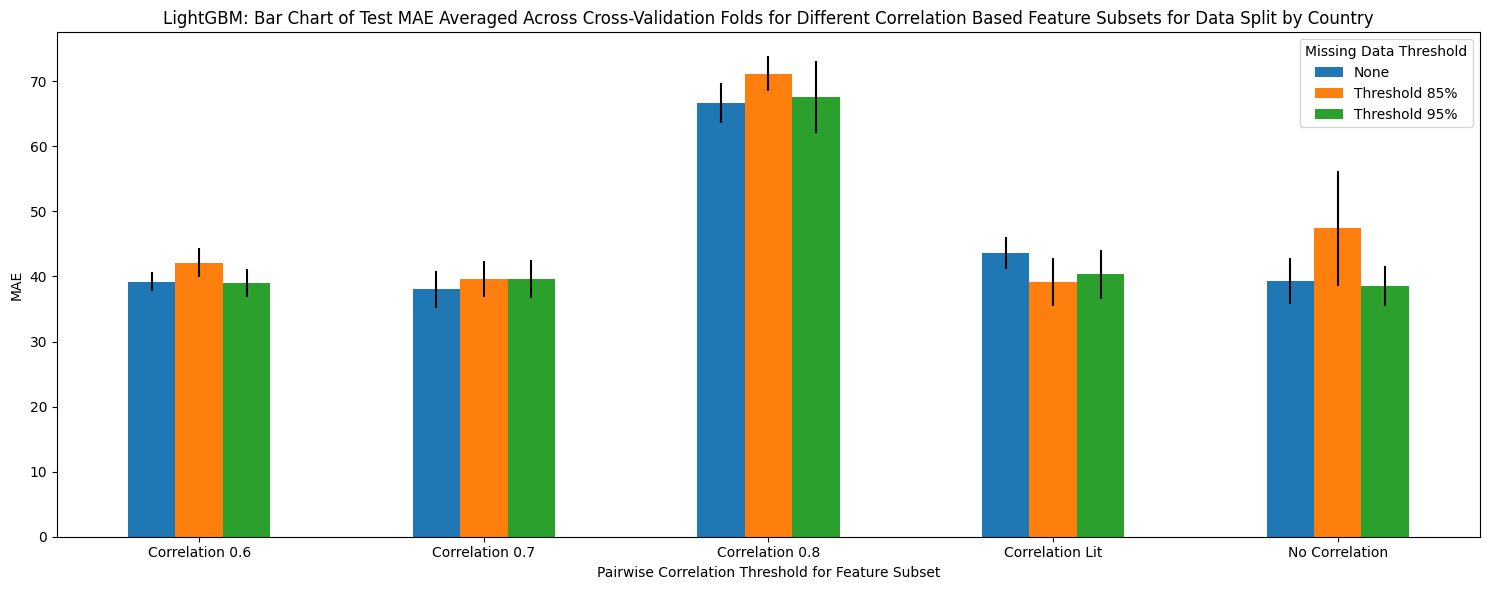

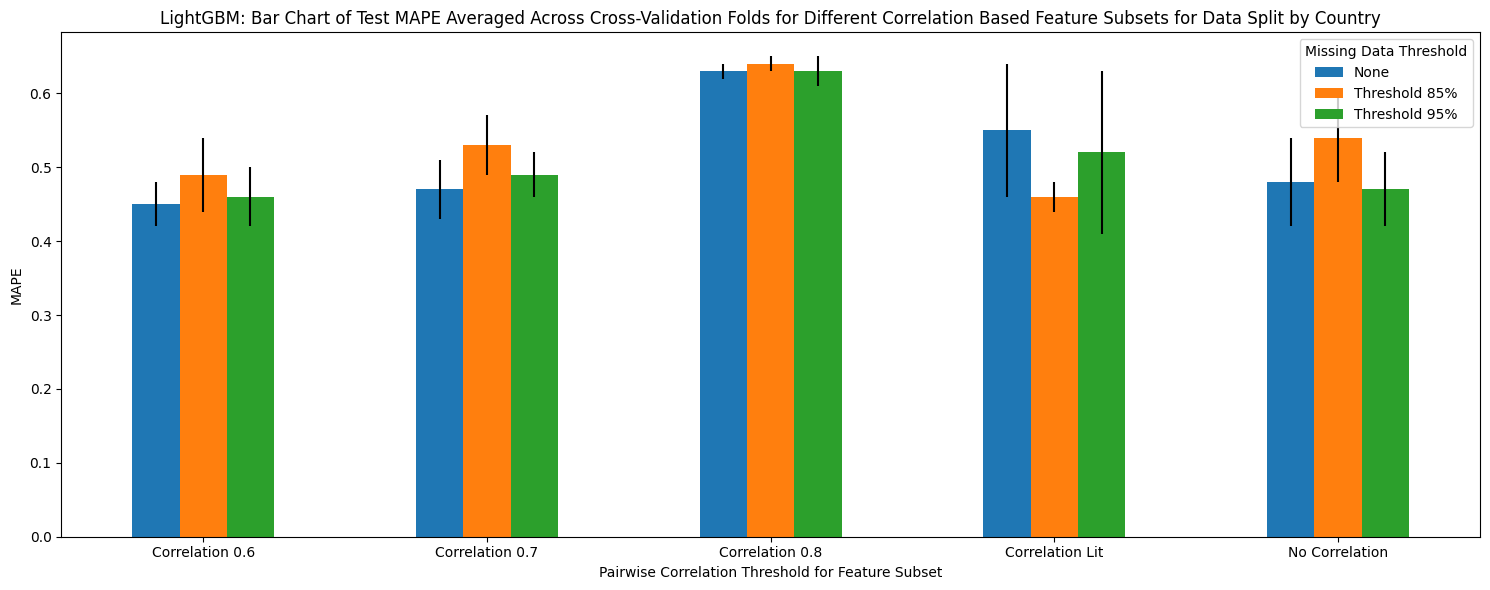

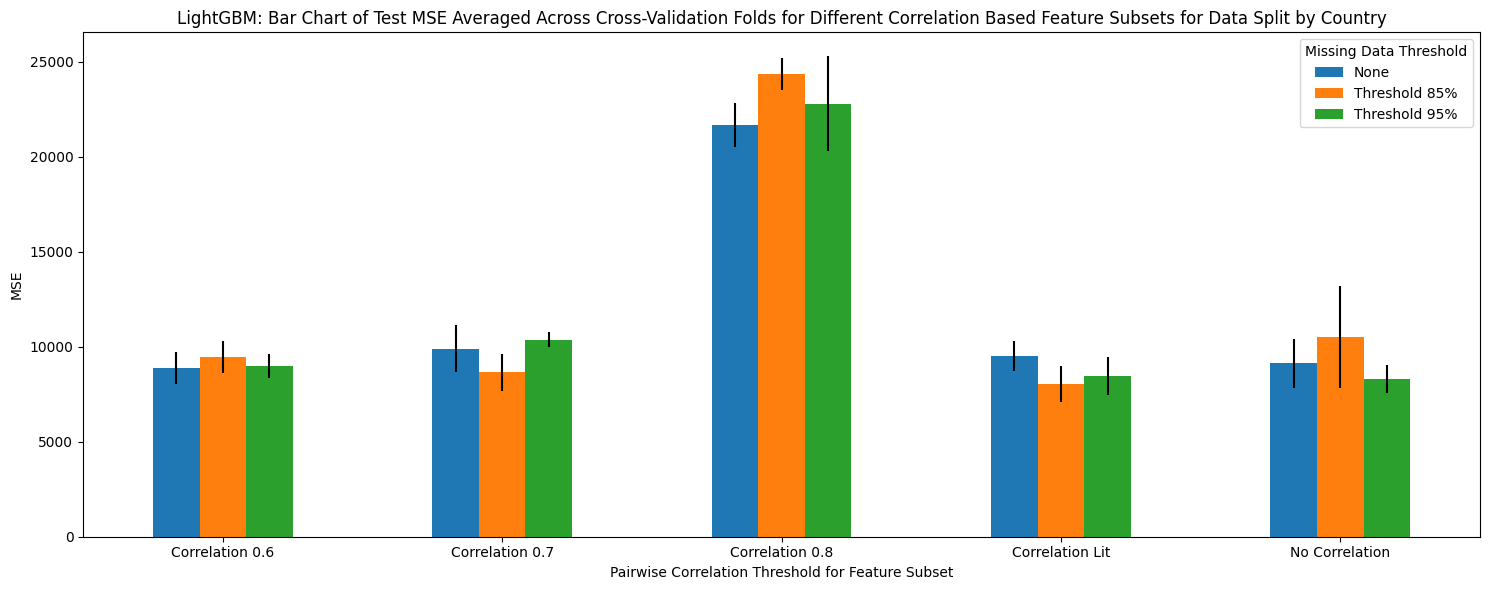

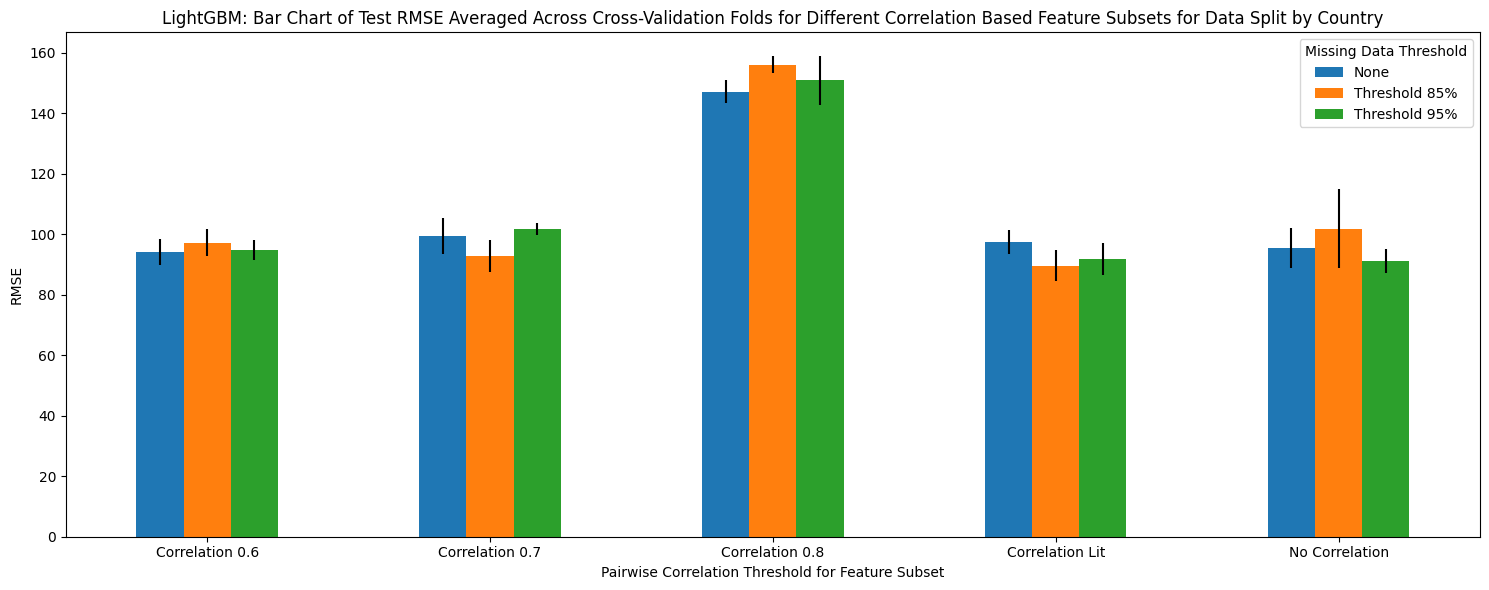

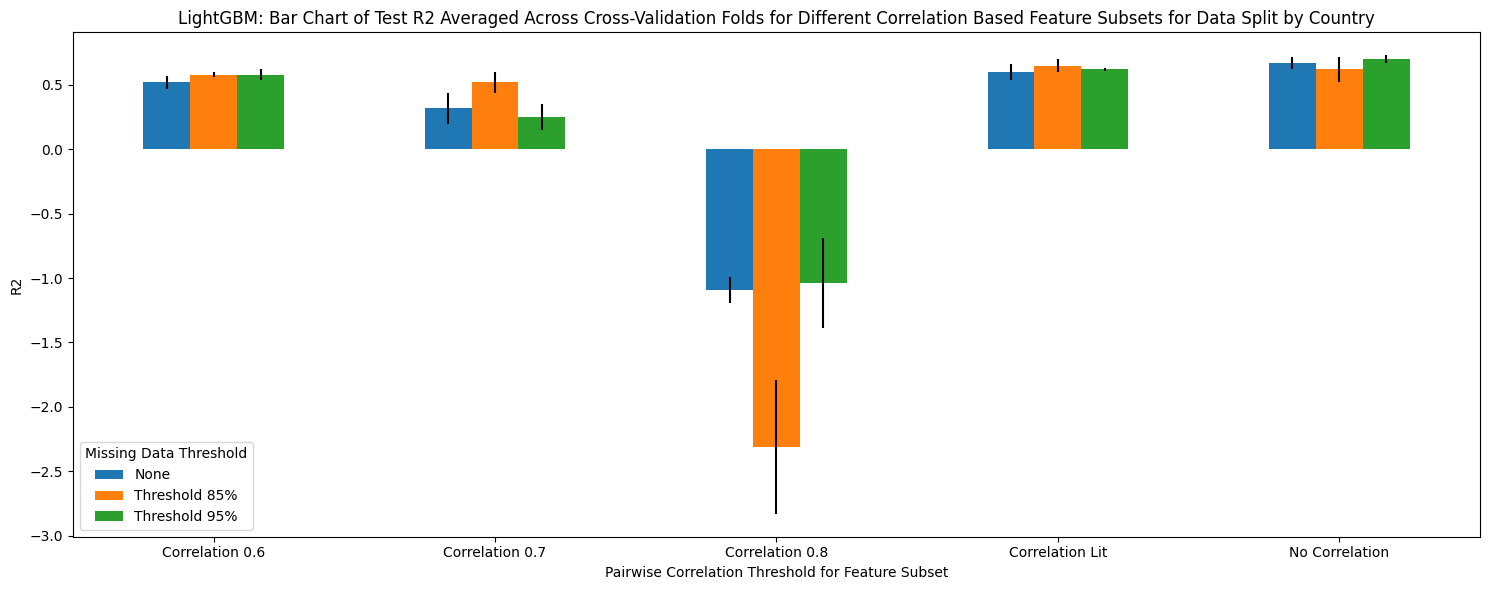

In [149]:
mean_data_lgb = all_data_lgb.astype(float)
std_data_lgb = all_std_data_lgb.astype(float)

for metric in ['MAE', 'MAPE', 'MSE', 'RMSE', 'R2']:
    mean_vals = mean_data_lgb[metric].unstack(level='Missing Data Threshold')
    std_vals = std_data_lgb[metric].unstack(level='Missing Data Threshold')
    mean_vals.plot.bar(yerr=std_vals, figsize=(15, 6), rot=0)
    plt.title("LightGBM: Bar Chart of Test " + metric + " Averaged Across Cross-Validation Folds for Different Correlation Based Feature Subsets for Data Split by Country")
    plt.xlabel("Pairwise Correlation Threshold for Feature Subset")
    plt.ylabel(metric)
    plt.tight_layout()
    plt.show()

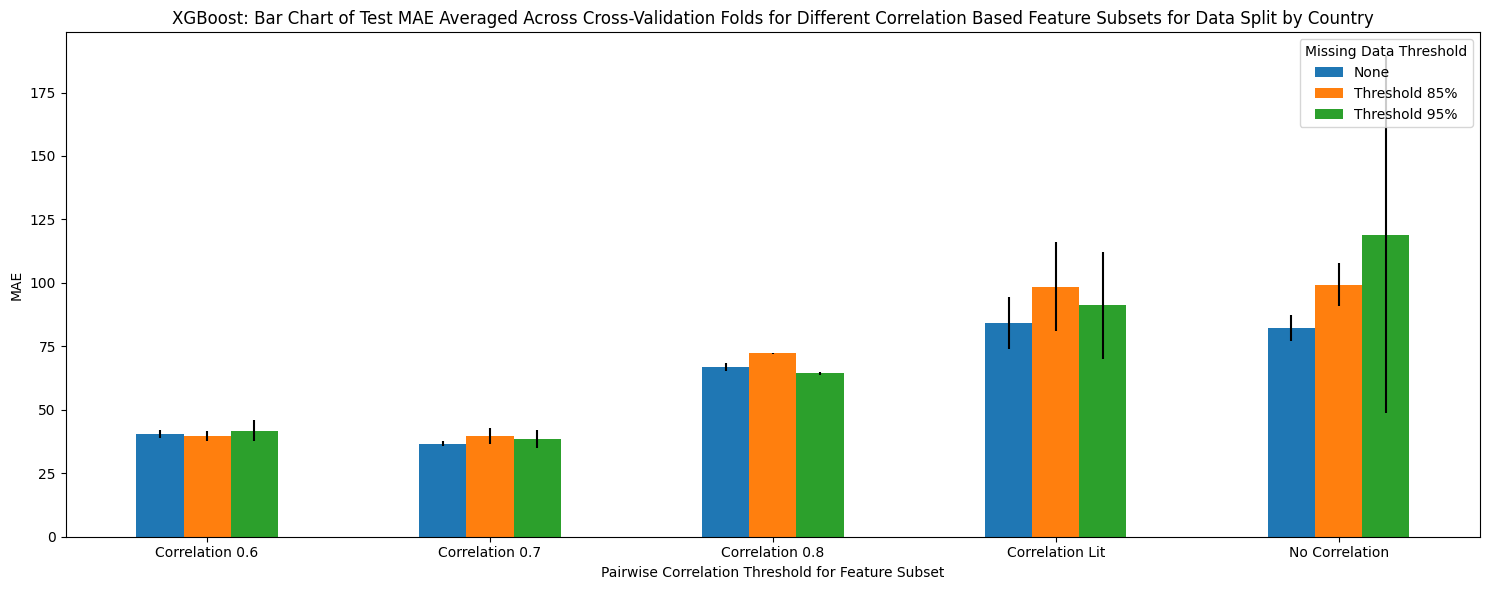

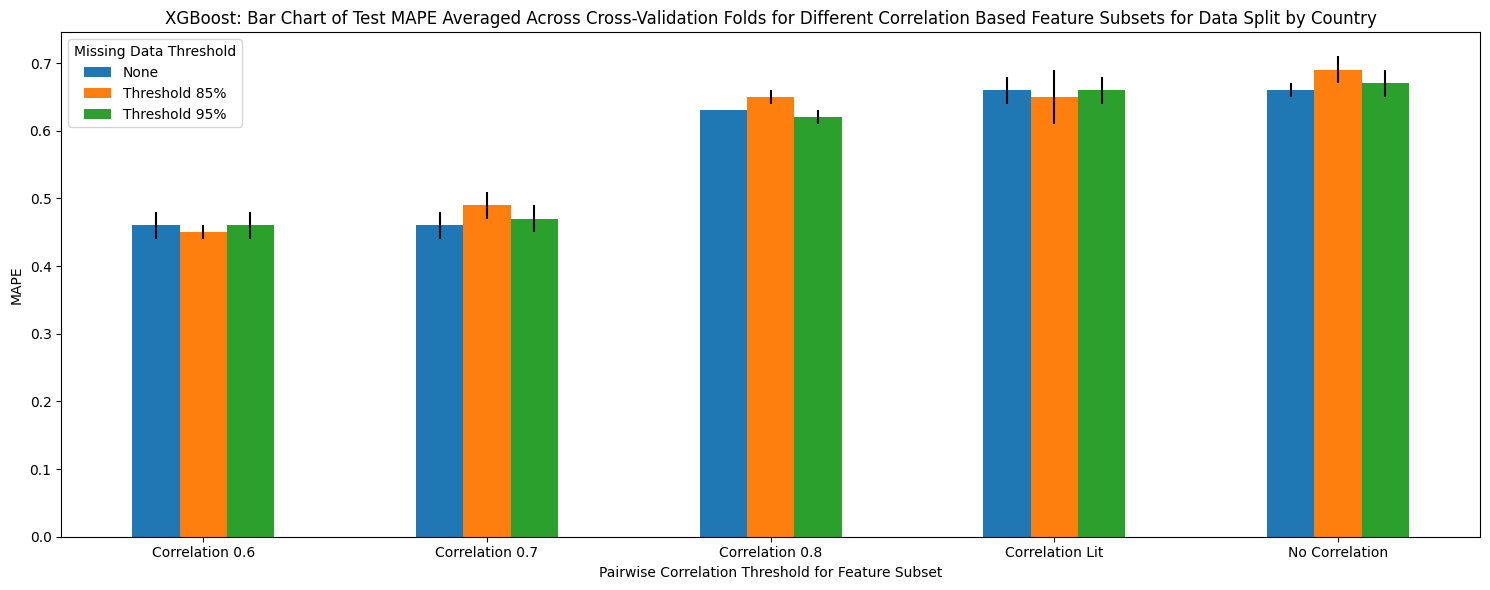

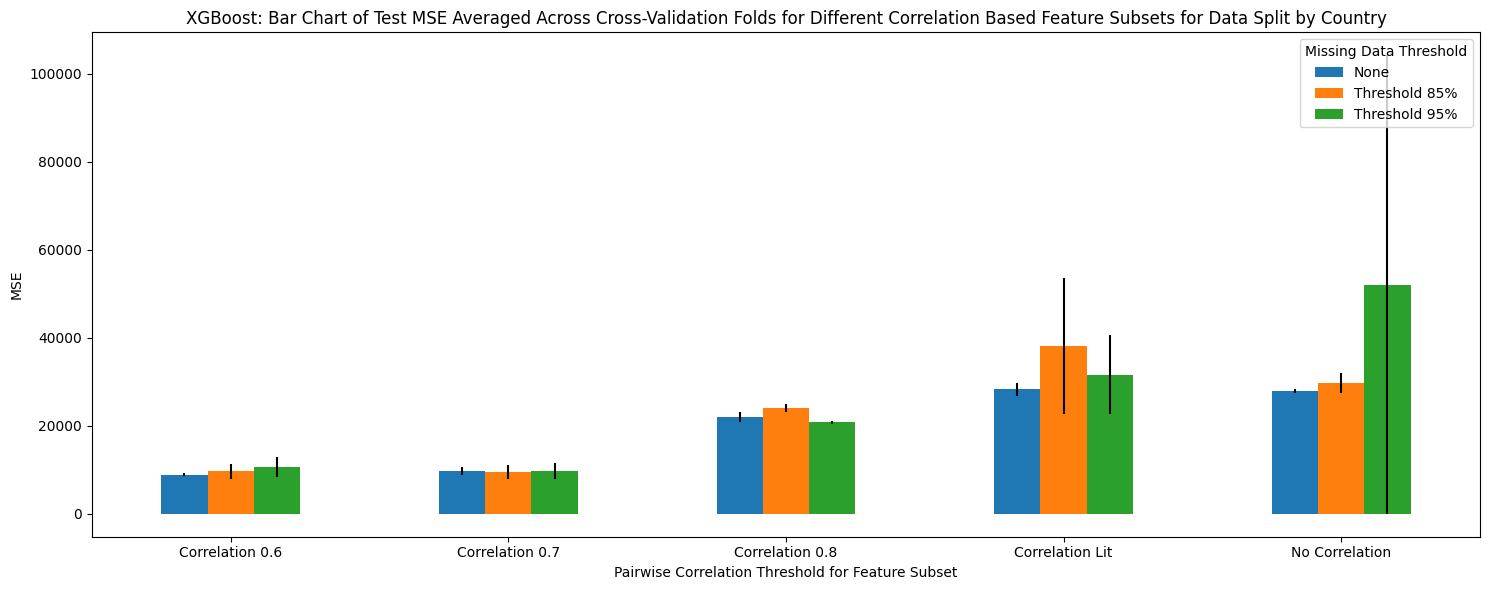

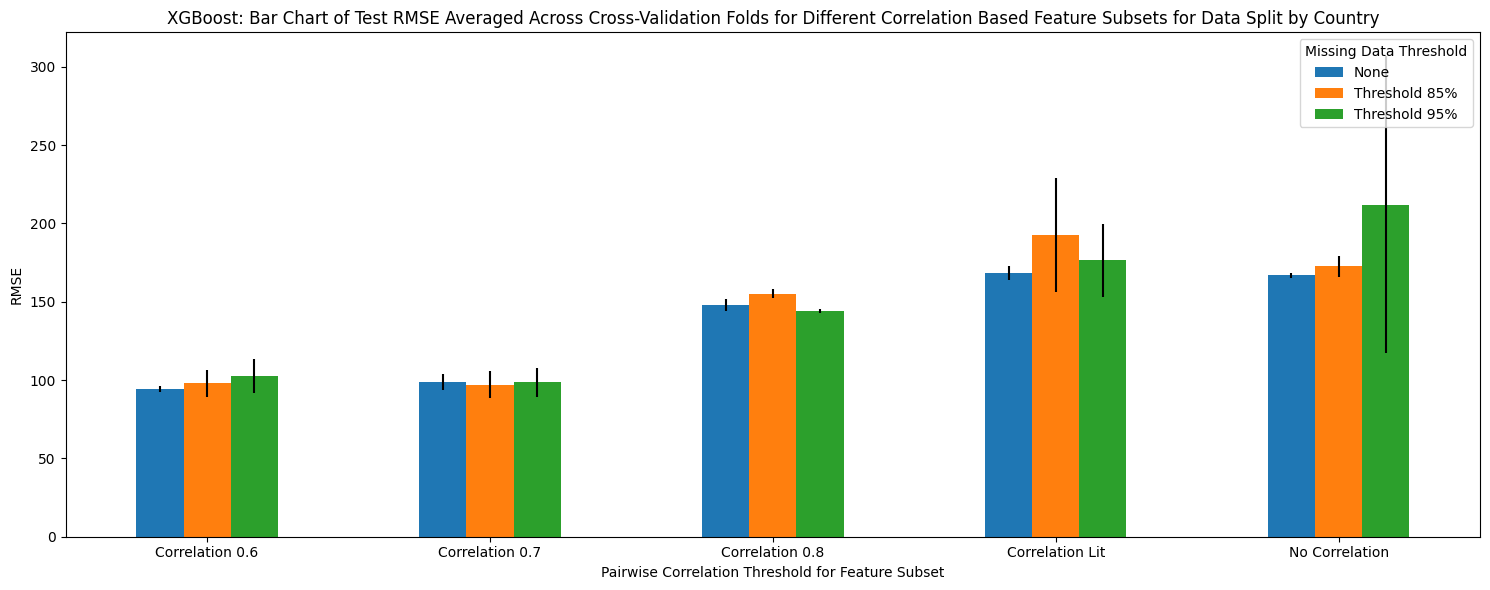

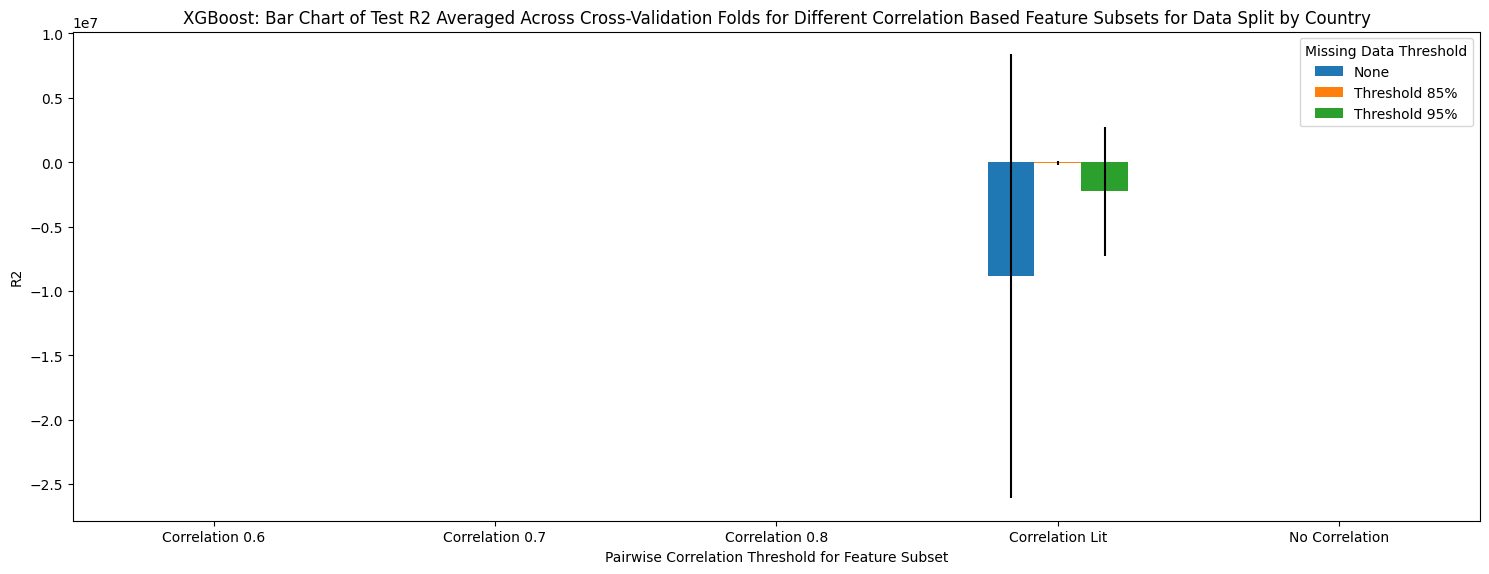

In [150]:
mean_data_xgb = all_data_xgb.astype(float)
std_data_xgb = all_std_data_xgb.astype(float)

for metric in ['MAE', 'MAPE', 'MSE', 'RMSE', 'R2']:
    mean_vals = mean_data_xgb[metric].unstack(level='Missing Data Threshold')
    std_vals = std_data_xgb[metric].unstack(level='Missing Data Threshold')
    mean_vals.plot.bar(yerr=std_vals, figsize=(15, 6), rot=0)
    plt.title("XGBoost: Bar Chart of Test " + metric + " Averaged Across Cross-Validation Folds for Different Correlation Based Feature Subsets for Data Split by Country")
    plt.xlabel("Pairwise Correlation Threshold for Feature Subset")
    plt.ylabel(metric)
    plt.tight_layout()
    plt.show()

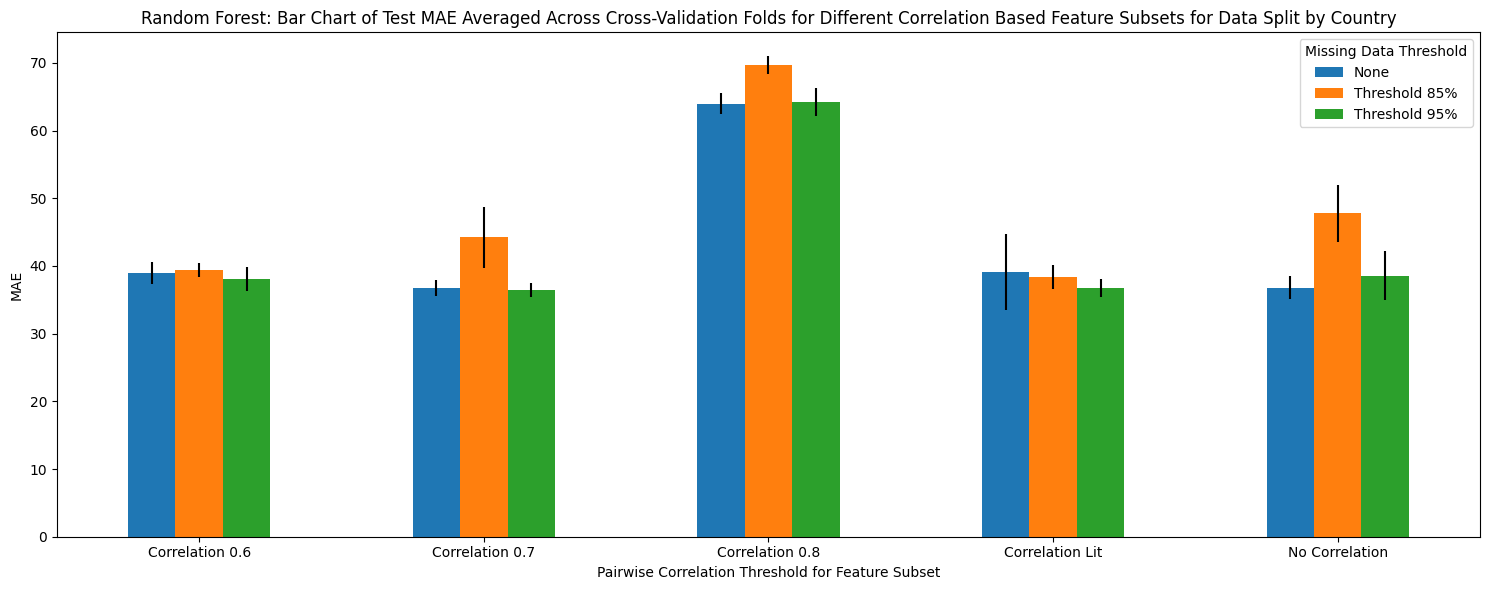

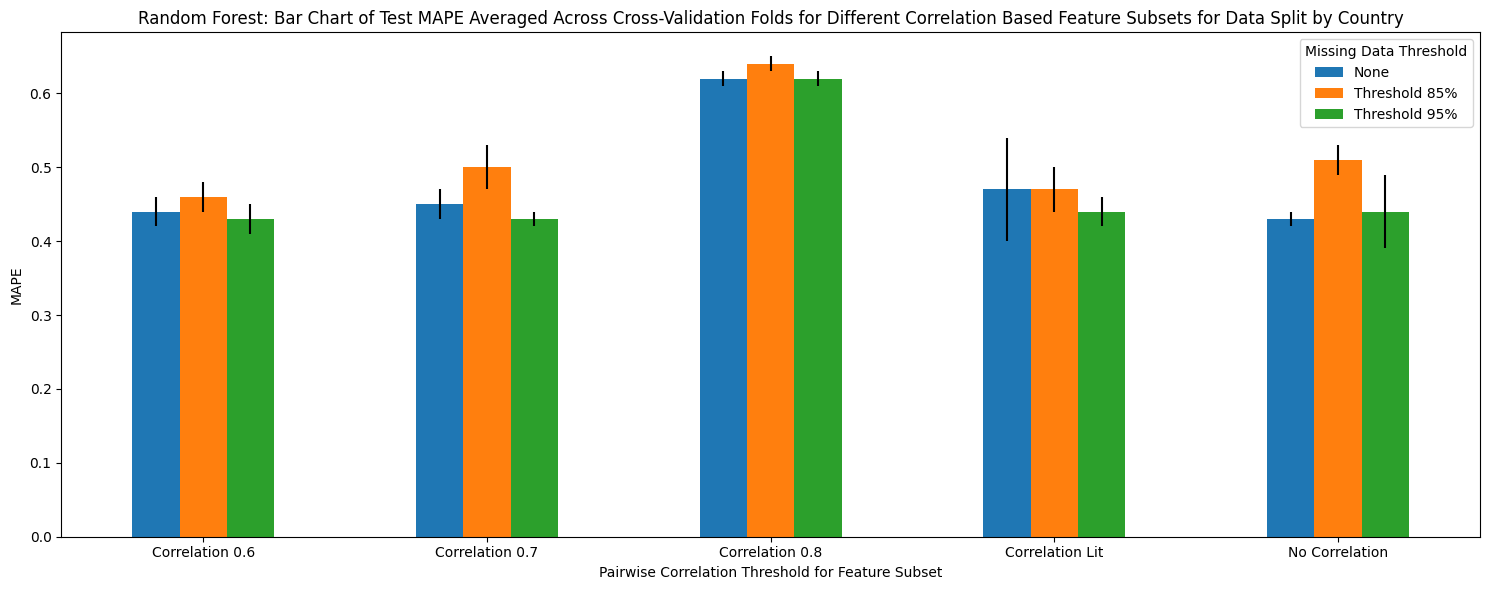

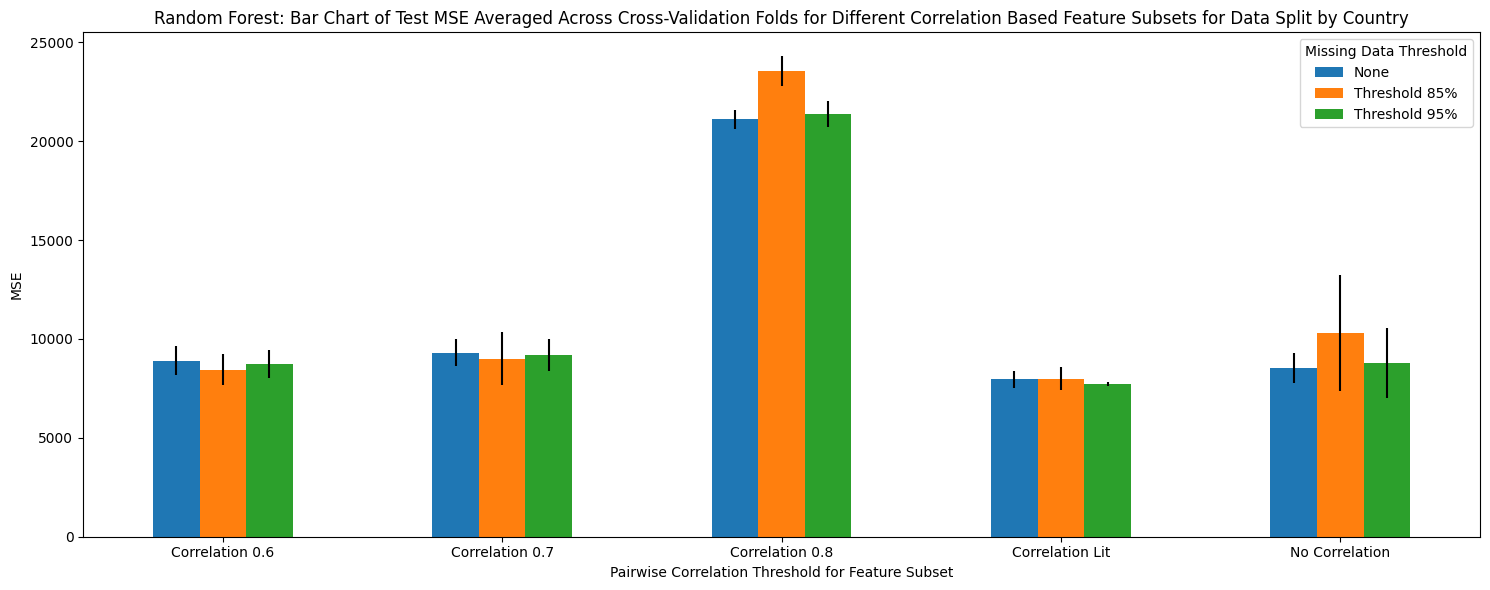

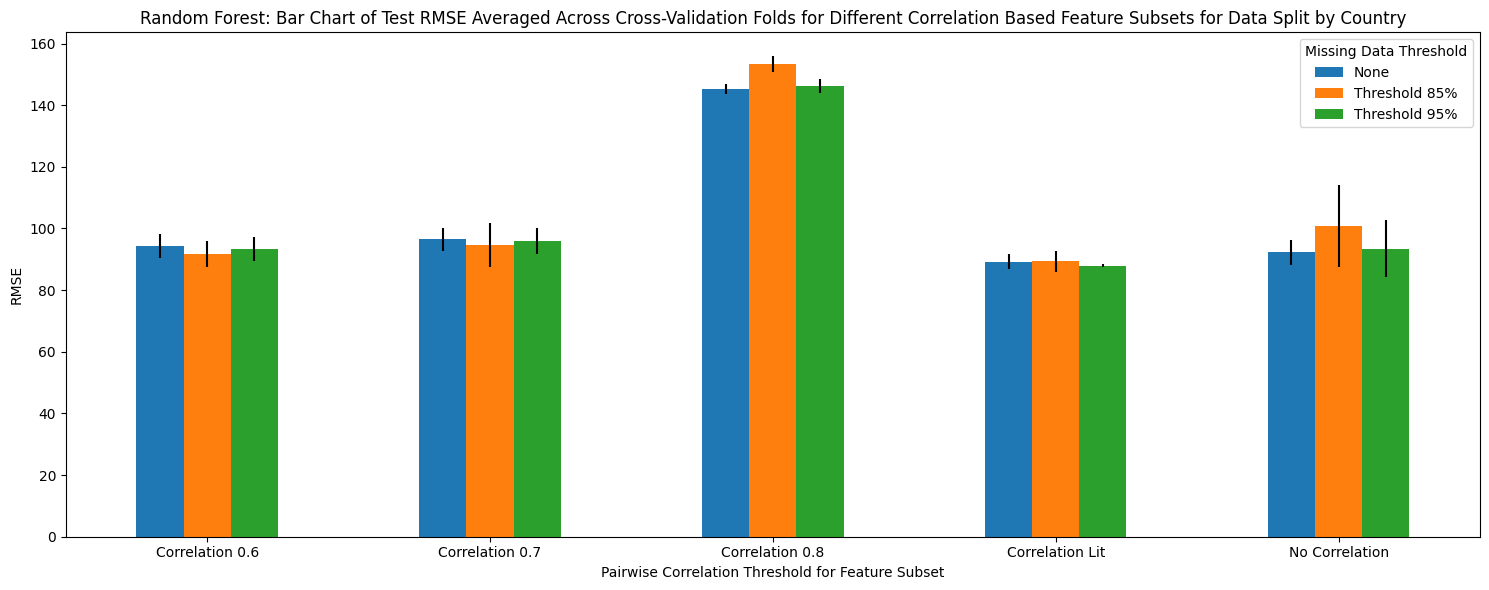

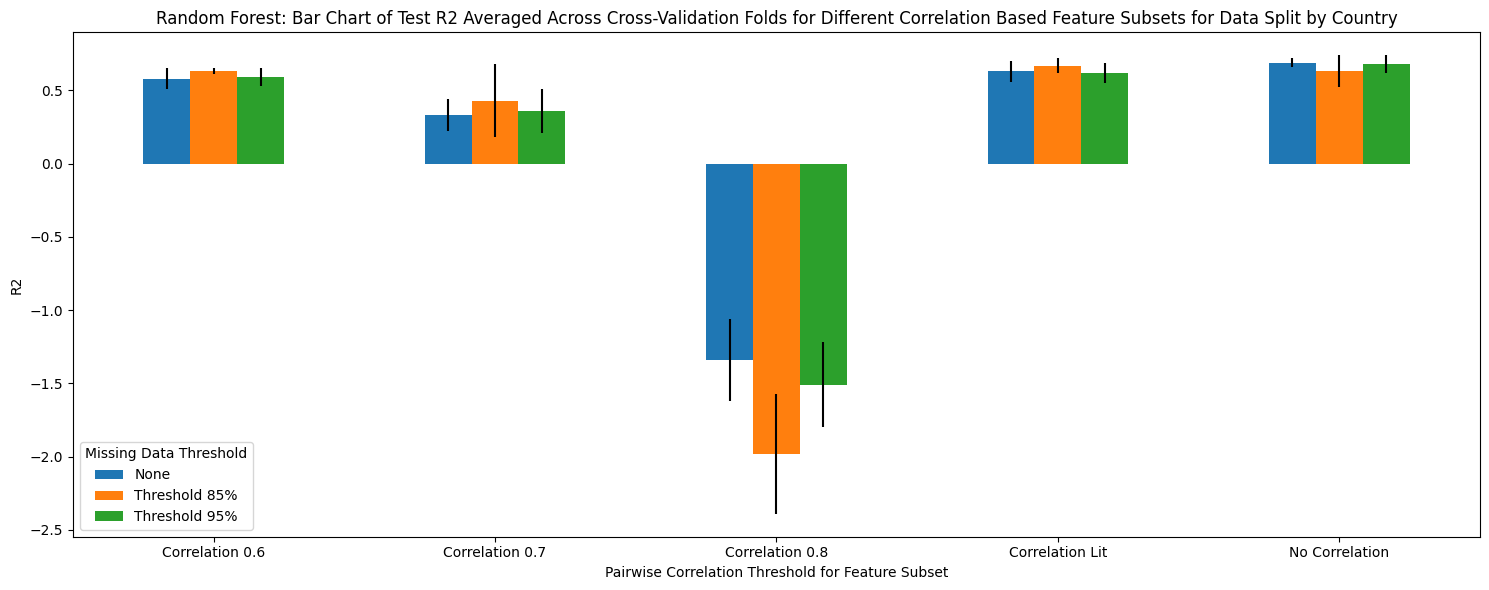

In [151]:
mean_data_rf = all_data_rf.astype(float)
std_data_rf = all_std_data_rf.astype(float)

for metric in ['MAE', 'MAPE', 'MSE', 'RMSE', 'R2']:
    mean_vals = mean_data_rf[metric].unstack(level='Missing Data Threshold')
    std_vals = std_data_rf[metric].unstack(level='Missing Data Threshold')
    mean_vals.plot.bar(yerr=std_vals, figsize=(15, 6), rot=0)
    plt.title("Random Forest: Bar Chart of Test " + metric + " Averaged Across Cross-Validation Folds for Different Correlation Based Feature Subsets for Data Split by Country")
    plt.xlabel("Pairwise Correlation Threshold for Feature Subset")
    plt.ylabel(metric)
    plt.tight_layout()
    plt.show()

#### Plotting Best

In [ ]:



for metric in ['MAE', 'MAPE', 'MSE', 'RMSE', 'R2']:
    mean_vals = mean_data_xgb[metric].unstack(level='Missing Data Threshold')
    std_vals = std_data_xgb[metric].unstack(level='Missing Data Threshold')
    mean_vals.plot.bar(yerr=std_vals, figsize=(15, 6), rot=0)
    plt.title("XGBoost: Bar Chart of Test " + metric + " Averaged Across Cross-Validation Folds for Different Correlation Based Feature Subsets for Data Split by Country")
    plt.xlabel("Pairwise Correlation Threshold for Feature Subset")
    plt.ylabel(metric)
    plt.tight_layout()
    plt.show()

## By Year

### Loading Data

In [152]:
filepath_year = '../fs_corr_year_data'

In [153]:
test_data_x60_year = pd.read_csv(filepath_year + '/test/60/X_test.csv')
test_data_x60_year = test_data_x60_year.drop(columns=['Unnamed: 0'], axis=1)
test_data_y60_year = pd.read_csv(filepath_year + '/test/60/y_test.csv')
test_data_y60_year = test_data_y60_year.drop(columns=['Unnamed: 0'], axis=1)

test_data_x70_year = pd.read_csv(filepath_year + '/test/70/X_test.csv')
test_data_x70_year = test_data_x70_year.drop(columns=['Unnamed: 0'], axis=1)
test_data_y70_year = pd.read_csv(filepath_year + '/test/70/y_test.csv')
test_data_y70_year = test_data_y70_year.drop(columns=['Unnamed: 0'], axis=1)

test_data_x80_year = pd.read_csv(filepath_year + '/test/80/X_test.csv')
test_data_x80_year = test_data_x80_year.drop(columns=['Unnamed: 0'], axis=1)
test_data_y80_year = pd.read_csv(filepath_year + '/test/80/y_test.csv')
test_data_y80_year = test_data_y80_year.drop(columns=['Unnamed: 0'], axis=1)

In [154]:
validation_60_year = {}
validation_70_year = {}
validation_80_year = {}

for fold in range(0, 5):
    vdata_x60_year = pd.read_csv(filepath_year + '/val/60/X_val_' + str(fold) + '.csv')
    vdata_x60_year = vdata_x60_year.drop(columns=['Unnamed: 0'], axis=1)
    vdata_y60_year = pd.read_csv(filepath_year + '/val/60/y_val_' + str(fold) + '.csv')
    vdata_y60_year = vdata_y60_year.drop(columns=['Unnamed: 0'], axis=1)
    validation_60_year[fold] = [vdata_x60_year, vdata_y60_year]

    vdata_x70_year = pd.read_csv(filepath_year + '/val/70/X_val_' + str(fold) + '.csv')
    vdata_x70_year = vdata_x70_year.drop(columns=['Unnamed: 0'], axis=1)
    vdata_y70_year = pd.read_csv(filepath_year + '/val/70/y_val_' + str(fold) + '.csv')
    vdata_y70_year = vdata_y70_year.drop(columns=['Unnamed: 0'], axis=1)
    validation_70_year[fold] = [vdata_x70_year, vdata_y70_year]

    vdata_x80_year = pd.read_csv(filepath_year + '/val/80/X_val_' + str(fold) + '.csv')
    vdata_x80_year = vdata_x80_year.drop(columns=['Unnamed: 0'], axis=1)
    vdata_y80_year = pd.read_csv(filepath_year + '/val/80/y_val_' + str(fold) + '.csv')
    vdata_y80_year = vdata_y80_year.drop(columns=['Unnamed: 0'], axis=1)
    validation_80_year[fold] = [vdata_x80_year, vdata_y80_year]

In [155]:
train_60_year = {}
train_70_year = {}
train_80_year = {}

for corr_idx, corr in enumerate(['60', '70', '80']):
    for fold in range(0, 5):
        tdata_x85 = pd.read_csv(filepath_year + '/train/' + corr + '/X_train_' + str(fold) + '_85.csv')
        tdata_x85 = tdata_x85.drop(columns=['Unnamed: 0'], axis=1)
        tdata_y85 = pd.read_csv(filepath_year + '/train/' + corr + '/y_train_' + str(fold) + '_85.csv')
        tdata_y85 = tdata_y85.drop(columns=['Unnamed: 0'], axis=1)

        tdata_x95 = pd.read_csv(filepath_year + '/train/' + corr + '/X_train_' + str(fold) + '_95.csv')
        tdata_x95 = tdata_x95.drop(columns=['Unnamed: 0'], axis=1)
        tdata_y95 = pd.read_csv(filepath_year + '/train/' + corr + '/y_train_' + str(fold) + '_95.csv')
        tdata_y95 = tdata_y95.drop(columns=['Unnamed: 0'], axis=1)

        tdata_x1 = pd.read_csv(filepath_year + '/train/' + corr + '/X_train_' + str(fold) + '_1.csv')
        tdata_x1 = tdata_x1.drop(columns=['Unnamed: 0'], axis=1)
        tdata_y1 = pd.read_csv(filepath_year + '/train/' + corr + '/y_train_' + str(fold) + '_1.csv')
        tdata_y1 = tdata_y1.drop(columns=['Unnamed: 0'], axis=1)

        if corr_idx == 0:
            train_60_year[fold] = [tdata_x85, tdata_y85, tdata_x95, tdata_y95, tdata_x1, tdata_y1]
        if corr_idx == 1:
            train_70_year[fold] = [tdata_x85, tdata_y85, tdata_x95, tdata_y95, tdata_x1, tdata_y1]
        else: train_80_year[fold] = [tdata_x85, tdata_y85, tdata_x95, tdata_y95, tdata_x1, tdata_y1]

### Gathering Test Values

In [105]:
# setting up the dataframe to hold test results
test_stats_corr_rf_year = pd.DataFrame(index=index, columns=['MAPE', 'MAE', 'MSE', 'RMSE', 'R2'])
test_stats_corr_xgb_year = pd.DataFrame(index=index, columns=['MAPE', 'MAE', 'MSE', 'RMSE', 'R2'])
test_stats_corr_lgb_year = pd.DataFrame(index=index, columns=['MAPE', 'MAE', 'MSE', 'RMSE', 'R2'])

In [157]:
output_dir_lgb_year = '../feature_selection_models/by_year/lightgbm'
output_dir_lgb_lit_year = '../fs_fromlit_models/year/lightgbm'

for corr_idx, corr in enumerate(['60', '70', '80', 'lit']):
    testing_datax = None
    testing_datay = None
    training_data = None
    if corr_idx == 0:
        testing_datax = test_data_x60_year.copy()
        testing_datay = test_data_y60_year.copy()
        training_data = train_60_year
    elif corr_idx == 1:
        testing_datax = test_data_x70_year.copy()
        testing_datay = test_data_y70_year.copy()
        training_data = train_70_year
    elif corr_idx == 2:
        testing_datax = test_data_x80_year.copy()
        testing_datay = test_data_y80_year.copy()
        training_data = train_80_year
    elif corr_idx == 3:
        testing_datax = test_data_x_lit_year.copy()
        testing_datay = test_data_y_lit_year.copy()
        training_data = train_lit_year
    
    testing_datax.columns = testing_datax.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)
    testing_datay.column = 'Maternal mortality ratio (national estimate per 100000 live births)'

    corr_name = ''
    table_corr_name = ''
    if corr_idx == 0:
        corr_name = 'corr_60'
        table_corr_name = 'Correlation 0.6'
    elif corr_idx == 1:
        corr_name = 'corr_70'
        table_corr_name = 'Correlation 0.7'
    elif corr_idx == 2: 
        corr_name = 'corr_80'
        table_corr_name = 'Correlation 0.8'
    elif corr_idx == 3: 
        table_corr_name = 'Correlation Lit'

    for fold, fold_num in enumerate(['1', '2', '3', '4', '5']):
        for thresh, thresh_name in enumerate(['Threshold 85%', 'Threshold 95%', 'None']):
            if fold == 0 and thresh_name == 'Threshold 85%' and corr_name == 'corr_80':
                continue

            if thresh == 0:
                name = '85'
            elif thresh == 1:
                name = '95'
            else: name = '1'

            if corr_idx !=3 :
                best_params = joblib.load(f"{output_dir_lgb_year}/best_params_{corr_name}_{fold}_{name}.pkl")
            else:
                best_params = joblib.load(f"{output_dir_lgb_lit_year}/best_params_{fold}_{name}.pkl")

            train_input_data = training_data[fold][thresh * 2].copy()
            train_input_data.columns = train_input_data.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)

            train_label = training_data[fold][thresh * 2 + 1].copy()
            train_label.column = 'Maternal mortality ratio (national estimate per 100000 live births)'

            to_test = testing_datax[train_input_data.columns].copy()

            if corr_idx == 3:
                train_input_data['setting'] = train_input_data['setting'].astype("category")
                to_test['setting'] = to_test['setting'].astype("category")

            loaded_model = lgb.LGBMRegressor(**best_params, verbosity = -1)
            train_load = loaded_model.fit(train_input_data, train_label)
            prediction = train_load.predict(to_test)
            mse = mean_squared_error(prediction, testing_datay)
            mae = mean_absolute_error(prediction, testing_datay)
            rmse = np.sqrt(mse)
            r2 = r2_score(prediction, testing_datay)

            #to calculate mape
            num_predictions = len(prediction)
            mape = 0
            for p in range(0, num_predictions):
                mape += np.abs(prediction[p] - testing_datay.iloc[p]) / np.maximum(np.abs(prediction[p]), np.abs(testing_datay.iloc[p]))
            mape = mape/num_predictions

            test_stats_corr_lgb_year.loc[(table_corr_name, thresh_name, fold_num), 'MSE'] = mse
            test_stats_corr_lgb_year.loc[(table_corr_name, thresh_name, fold_num), 'MAE'] = mae
            test_stats_corr_lgb_year.loc[(table_corr_name, thresh_name, fold_num), 'RMSE'] = rmse
            test_stats_corr_lgb_year.loc[(table_corr_name, thresh_name, fold_num), 'R2'] = r2
            test_stats_corr_lgb_year.loc[(table_corr_name, thresh_name, fold_num), 'MAPE'] = mape[0]

/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_5589/1296608446.py:89: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_stats_corr_lgb_year.loc[(table_corr_name, thresh_name, fold_num), 'MAPE'] = mape[0]
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_5589/1296608446.py:89: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_stats_corr_lgb_year.loc[(table_corr_name, thresh_name, fold_num), 'MAPE'] = mape[0]
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_5589/1296608446.py:89: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer key

In [156]:
output_dir_xgb_year = '../feature_selection_models/by_year/xgboost'
output_dir_xgb_lit_year = '../fs_fromlit_models/year/xgboost'

for corr_idx, corr in enumerate(['60', '70', '80', 'lit']):
    testing_datax = None
    testing_datay = None
    training_data = None
    if corr_idx == 0:
        testing_datax = test_data_x60_year.copy()
        testing_datay = test_data_y60_year.copy()
        training_data = train_60_year
    elif corr_idx == 1:
        testing_datax = test_data_x70_year.copy()
        testing_datay = test_data_y70_year.copy()
        training_data = train_70_year
    elif corr_idx == 2:
        testing_datax = test_data_x80_year.copy()
        testing_datay = test_data_y80_year.copy()
        training_data = train_80_year
    elif corr_idx == 3:
        testing_datax = test_data_x_lit_year.copy()
        testing_datay = test_data_y_lit_year.copy()
        training_data = train_lit_year
    
    corr_name = ''
    table_corr_name = ''
    if corr_idx == 0:
        corr_name = 'corr_60'
        table_corr_name = 'Correlation 0.6'
    elif corr_idx == 1:
        corr_name = 'corr_70'
        table_corr_name = 'Correlation 0.7'
    elif corr_idx == 2: 
        corr_name = 'corr_80'
        table_corr_name = 'Correlation 0.8'
    elif corr_idx == 3: 
        table_corr_name = 'Correlation Lit'

    for fold, fold_num in enumerate(['1', '2', '3', '4', '5']):
        for thresh, thresh_name in enumerate(['Threshold 85%', 'Threshold 95%', 'None']):
            if fold == 0 and thresh_name == 'Threshold 85%' and corr_name == 'corr_80':
                continue

            if thresh == 0:
                name = '85'
            elif thresh == 1:
                name = '95'
            else: name = '1'

            if corr_idx !=3 :
                bp = joblib.load(f"{output_dir_xgb_year}/best_params_{corr_name}_{fold}_{name}.pkl")
            else:
                bp = joblib.load(f"{output_dir_xgb_lit_year}/best_params_{fold}_{name}.pkl")
                
            
            best_params = {'n_estimators' : bp['number_trees'], 'max_depth' : bp['max_tree_depth'], 'booster' : bp['boosting_type'], 'reg_alpha' : bp['l1_norm'], 
            'reg_lambda' : bp['l2_norm'], 'subsample' : bp['subsample'], 'learning_rate' : bp['learning_rate']}

            train_input_data = training_data[fold][thresh * 2].copy()

            train_label = training_data[fold][thresh * 2 + 1].copy()

            to_test = testing_datax[train_input_data.columns].copy()

            if corr_idx == 3:
                train_input_data['setting'] = train_input_data['setting'].astype("category")
                to_test['setting'] = to_test['setting'].astype("category")

            loaded_model = xgb.XGBRegressor(**best_params, enable_categorical=True)
            train_load = loaded_model.fit(train_input_data, train_label)
            prediction = train_load.predict(to_test)
            mse = mean_squared_error(prediction, testing_datay)
            mae = mean_absolute_error(prediction, testing_datay)
            rmse = np.sqrt(mse)
            r2 = r2_score(prediction, testing_datay)

            #to calculate mape
            num_predictions = len(prediction)
            mape = 0
            for p in range(0, num_predictions):
                mape += np.abs(prediction[p] - testing_datay.iloc[p]) / np.maximum(np.abs(prediction[p]), np.abs(testing_datay.iloc[p]))
            mape = mape/num_predictions

            test_stats_corr_xgb_year.loc[(table_corr_name, thresh_name, fold_num), 'MSE'] = mse
            test_stats_corr_xgb_year.loc[(table_corr_name, thresh_name, fold_num), 'MAE'] = mae
            test_stats_corr_xgb_year.loc[(table_corr_name, thresh_name, fold_num), 'RMSE'] = rmse
            test_stats_corr_xgb_year.loc[(table_corr_name, thresh_name, fold_num), 'R2'] = r2
            test_stats_corr_xgb_year.loc[(table_corr_name, thresh_name, fold_num), 'MAPE'] = mape[0]

/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_5589/3408421978.py:88: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_stats_corr_xgb_year.loc[(table_corr_name, thresh_name, fold_num), 'MAPE'] = mape[0]
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_5589/3408421978.py:88: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_stats_corr_xgb_year.loc[(table_corr_name, thresh_name, fold_num), 'MAPE'] = mape[0]
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_5589/3408421978.py:88: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer key

In [162]:
output_dir_rf_year = '../feature_selection_models/by_year/random_forest'
output_dir_rf_lit_year = '../fs_fromlit_models/year/rf'

for corr_idx, corr in enumerate(['60', '70', '80', 'lit']):
    testing_datax = None
    testing_datay = None
    training_data = None
    if corr_idx == 0:
        testing_datax = test_data_x60_year.copy()
        testing_datay = test_data_y60_year.copy()
        training_data = train_60_year
    elif corr_idx == 1:
        testing_datax = test_data_x70_year.copy()
        testing_datay = test_data_y70_year.copy()
        training_data = train_70_year
    elif corr_idx == 2:
        testing_datax = test_data_x80_year.copy()
        testing_datay = test_data_y80_year.copy()
        training_data = train_80_year
    elif corr_idx == 3:
        testing_datax = test_data_x_lit_year.copy()
        testing_datay = test_data_y_lit_year.copy()
        training_data = train_lit_year
    
    corr_name = ''
    table_corr_name = ''
    if corr_idx == 0:
        corr_name = 'corr_60'
        table_corr_name = 'Correlation 0.6'
    elif corr_idx == 1:
        corr_name = 'corr_70'
        table_corr_name = 'Correlation 0.7'
    elif corr_idx == 2: 
        corr_name = 'corr_80'
        table_corr_name = 'Correlation 0.8'
    elif corr_idx == 3: 
        table_corr_name = 'Correlation Lit'

    for fold, fold_num in enumerate(['1', '2', '3', '4', '5']):
        for thresh, thresh_name in enumerate(['Threshold 85%', 'Threshold 95%', 'None']):
            if fold == 0 and thresh_name == 'Threshold 85%' and corr_name == 'corr_80':
                continue

            if thresh == 0:
                name = '85'
            elif thresh == 1:
                name = '95'
            else: name = '1'

            if corr_idx != 3:
                best_params = joblib.load(f"{output_dir_rf_year}/best_params_{corr_name}_{fold}_{name}.pkl")
            else:
                best_params = joblib.load(f"{output_dir_rf_lit_year}/best_params_{fold}_{name}.pkl")

            train_input_data = training_data[fold][thresh * 2].copy()

            train_label = training_data[fold][thresh * 2 + 1].copy()

            to_test = testing_datax[train_input_data.columns].copy()

            if corr_idx == 3:
                train_input_data['setting'] = train_input_data['setting'].map(countries_dict_inc)
                train_input_data['setting'] = train_input_data['setting'].astype("category")
                to_test['setting'] = to_test['setting'].map(countries_dict_inc)
                to_test['setting'] = to_test['setting'].astype("category")

            loaded_model = RandomForestRegressor(**best_params)
            train_load = loaded_model.fit(train_input_data, train_label)
            prediction = train_load.predict(to_test)
            mse = mean_squared_error(prediction, testing_datay)
            mae = mean_absolute_error(prediction, testing_datay)
            rmse = np.sqrt(mse)
            r2 = r2_score(prediction, testing_datay)

            #to calculate mape
            num_predictions = len(prediction)
            mape = 0
            for p in range(0, num_predictions):
                mape += np.abs(prediction[p] - testing_datay.iloc[p]) / np.maximum(np.abs(prediction[p]), np.abs(testing_datay.iloc[p]))
            mape = mape/num_predictions

            test_stats_corr_rf_year.loc[(table_corr_name, thresh_name, fold_num), 'MSE'] = mse
            test_stats_corr_rf_year.loc[(table_corr_name, thresh_name, fold_num), 'MAE'] = mae
            test_stats_corr_rf_year.loc[(table_corr_name, thresh_name, fold_num), 'RMSE'] = rmse
            test_stats_corr_rf_year.loc[(table_corr_name, thresh_name, fold_num), 'R2'] = r2
            test_stats_corr_rf_year.loc[(table_corr_name, thresh_name, fold_num), 'MAPE'] = mape[0]

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_5589/1321598391.py:86: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_stats_corr_rf_year.loc[(table_corr_name, thresh_name, fold_num), 'MAPE'] = mape[0]
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel

In [158]:
mean_summary_lgb_year = test_stats_corr_lgb_year.groupby(['Correlation Subset', 'Missing Data Threshold']).mean()
mean_summary_lgb_year = mean_summary_lgb_year.astype('float')
mean_summary_lgb_year = mean_summary_lgb_year.round(2)
std_summary_lgb_year = test_stats_corr_lgb_year.groupby(['Correlation Subset', 'Missing Data Threshold']).std()
std_summary_lgb_year = std_summary_lgb_year.astype('float')
std_summary_lgb_year = std_summary_lgb_year.round(2)

In [159]:
mean_summary_xgb_year = test_stats_corr_xgb_year.groupby(['Correlation Subset', 'Missing Data Threshold']).mean()
mean_summary_xgb_year = mean_summary_xgb_year.astype('float')
mean_summary_xgb_year = mean_summary_xgb_year.round(2)
std_summary_xgb_year = test_stats_corr_xgb_year.groupby(['Correlation Subset', 'Missing Data Threshold']).std()
std_summary_xgb_year = std_summary_xgb_year.astype('float')
std_summary_xgb_year = std_summary_xgb_year.round(2)

In [163]:
mean_summary_rf_year = test_stats_corr_rf_year.groupby(['Correlation Subset', 'Missing Data Threshold']).mean()
mean_summary_rf_year = mean_summary_rf_year.astype('float')
mean_summary_rf_year = mean_summary_rf_year.round(2)
std_summary_rf_year = test_stats_corr_rf_year.groupby(['Correlation Subset', 'Missing Data Threshold']).std()
std_summary_rf_year = std_summary_rf_year.astype('float')
std_summary_rf_year = std_summary_rf_year.round(2)

### Gathering Base Values

In [164]:
mean_original_year = joblib.load('../split_year_models/base_mean_metrics.pkl')
std_original_year = joblib.load('../split_year_models/base_std_metrics.pkl')

In [165]:
no_corr_df_lgb_year = mean_original_year['LightGBM']
no_corr_df_lgb_year['Correlation Subset'] = 'No Correlation'
no_corr_df_lgb_year.set_index('Correlation Subset', append=True, inplace=True)
no_corr_df_lgb_year = no_corr_df_lgb_year.reorder_levels(['Correlation Subset', 'Missing Data Threshold'])
all_data_lgb_year = pd.concat([mean_summary_lgb_year, no_corr_df_lgb_year])

no_corr_std_lgb_year = std_original_year['LightGBM']
no_corr_std_lgb_year['Correlation Subset'] = 'No Correlation'
no_corr_std_lgb_year.set_index('Correlation Subset', append=True, inplace=True)
no_corr_std_lgb_year = no_corr_std_lgb_year.reorder_levels(['Correlation Subset', 'Missing Data Threshold'])
all_std_data_lgb_year = pd.concat([std_summary_lgb_year, no_corr_std_lgb_year])

/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_5589/1286131471.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_corr_df_lgb_year['Correlation Subset'] = 'No Correlation'
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_5589/1286131471.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_corr_std_lgb_year['Correlation Subset'] = 'No Correlation'


In [166]:
no_corr_df_xgb_year = mean_original_year['XGBoost']
no_corr_df_xgb_year['Correlation Subset'] = 'No Correlation'
no_corr_df_xgb_year.set_index('Correlation Subset', append=True, inplace=True)
no_corr_df_xgb_year = no_corr_df_xgb_year.reorder_levels(['Correlation Subset', 'Missing Data Threshold'])
all_data_xgb_year = pd.concat([mean_summary_xgb_year, no_corr_df_xgb_year])

no_corr_std_xgb_year = std_original_year['XGBoost']
no_corr_std_xgb_year['Correlation Subset'] = 'No Correlation'
no_corr_std_xgb_year.set_index('Correlation Subset', append=True, inplace=True)
no_corr_std_xgb_year = no_corr_std_xgb_year.reorder_levels(['Correlation Subset', 'Missing Data Threshold'])
all_std_data_xgb_year = pd.concat([std_summary_xgb_year, no_corr_std_xgb_year])

/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_5589/3745195249.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_corr_df_xgb_year['Correlation Subset'] = 'No Correlation'
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_5589/3745195249.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_corr_std_xgb_year['Correlation Subset'] = 'No Correlation'


In [167]:
no_corr_df_rf_year = mean_original_year['Random Forest']
no_corr_df_rf_year['Correlation Subset'] = 'No Correlation'
no_corr_df_rf_year.set_index('Correlation Subset', append=True, inplace=True)
no_corr_df_rf_year = no_corr_df_rf_year.reorder_levels(['Correlation Subset', 'Missing Data Threshold'])
all_data_rf_year = pd.concat([mean_summary_rf_year, no_corr_df_rf_year])

no_corr_std_rf_year = std_original_year['Random Forest']
no_corr_std_rf_year['Correlation Subset'] = 'No Correlation'
no_corr_std_rf_year.set_index('Correlation Subset', append=True, inplace=True)
no_corr_std_rf_year = no_corr_std_rf_year.reorder_levels(['Correlation Subset', 'Missing Data Threshold'])
all_std_data_rf_year = pd.concat([std_summary_rf_year, no_corr_std_rf_year])

/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_5589/3178690657.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_corr_df_rf_year['Correlation Subset'] = 'No Correlation'
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_5589/3178690657.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_corr_std_rf_year['Correlation Subset'] = 'No Correlation'


### Visualisation

In [187]:
result_dict_year_lgb = {}
result_dict_year_xgb = {}
result_dict_year_rf = {}

# Loop through each metric and compute the max % fold difference
for metric in ['MAPE', 'MSE', 'MAE']:
    result = test_stats_corr_rf_year.groupby(['Correlation Subset', 'Missing Data Threshold'])[metric].agg(
        lambda x: ((x.max() - x.min()) / x.mean()) * 100
    )
    result_dict_year_lgb[metric] = result

    result = test_stats_corr_xgb_year.groupby(['Correlation Subset', 'Missing Data Threshold'])[metric].agg(
        lambda x: ((x.max() - x.min()) / x.mean()) * 100
    )
    result_dict_year_xgb[metric] = result

    result = test_stats_corr_rf_year.groupby(['Correlation Subset', 'Missing Data Threshold'])[metric].agg(
        lambda x: ((x.max() - x.min()) / x.mean()) * 100
    )
    result_dict_year_rf[metric] = result   

In [189]:
print('LightGBM')
pd.DataFrame(result_dict_year_lgb)

LightGBM


MAPE        MSE        MAE
Correlation Subset Missing Data Threshold                                 
Correlation 0.6    None                    11.324395  34.979440  16.921293
                   Threshold 85%            6.549539  18.349868   5.262676
                   Threshold 95%            4.062233  32.037051   6.808375
Correlation 0.7    None                    12.613071  20.726861  12.509474
                   Threshold 85%            7.375355  32.848893  16.069792
                   Threshold 95%           18.939146  14.651164  10.469180
Correlation 0.8    None                     8.426555  23.823683  11.613827
                   Threshold 85%            1.406965  24.984890   6.543198
                   Threshold 95%            5.639167  21.197167   7.399037
Correlation Lit    None                    11.989298  17.575778  12.132520
                   Threshold 85%           22.280234  86.489566  56.052199
                   Threshold 95%            9.435958  14.741583   9.542196

In [191]:
print('Random Forest')
pd.DataFrame(result_dict_year_rf)

Random Forest


MAPE        MSE        MAE
Correlation Subset Missing Data Threshold                                 
Correlation 0.6    None                    11.324395  34.979440  16.921293
                   Threshold 85%            6.549539  18.349868   5.262676
                   Threshold 95%            4.062233  32.037051   6.808375
Correlation 0.7    None                    12.613071  20.726861  12.509474
                   Threshold 85%            7.375355  32.848893  16.069792
                   Threshold 95%           18.939146  14.651164  10.469180
Correlation 0.8    None                     8.426555  23.823683  11.613827
                   Threshold 85%            1.406965  24.984890   6.543198
                   Threshold 95%            5.639167  21.197167   7.399037
Correlation Lit    None                    11.989298  17.575778  12.132520
                   Threshold 85%           22.280234  86.489566  56.052199
                   Threshold 95%            9.435958  14.741583   9.542196

In [190]:
print('XGBoost')
pd.DataFrame(result_dict_year_xgb)

XGBoost


MAPE        MSE        MAE
Correlation Subset Missing Data Threshold                                 
Correlation 0.6    None                    21.292112  36.470196  19.902083
                   Threshold 85%           24.948891  36.607843  16.002199
                   Threshold 95%           13.108316  43.346294  17.354396
Correlation 0.7    None                    10.475982  27.279145  12.545989
                   Threshold 85%           21.590227  58.640102  30.429428
                   Threshold 95%           10.760442  26.202356  12.162004
Correlation 0.8    None                     8.138586  23.649483  15.978102
                   Threshold 85%            1.861564   8.700138   3.743000
                   Threshold 95%            4.163186  23.653216   4.477029
Correlation Lit    None                     1.745954   1.032092   4.504726
                   Threshold 85%            1.725385   1.068132   4.354405
                   Threshold 95%            1.880993   1.002775   5.587708

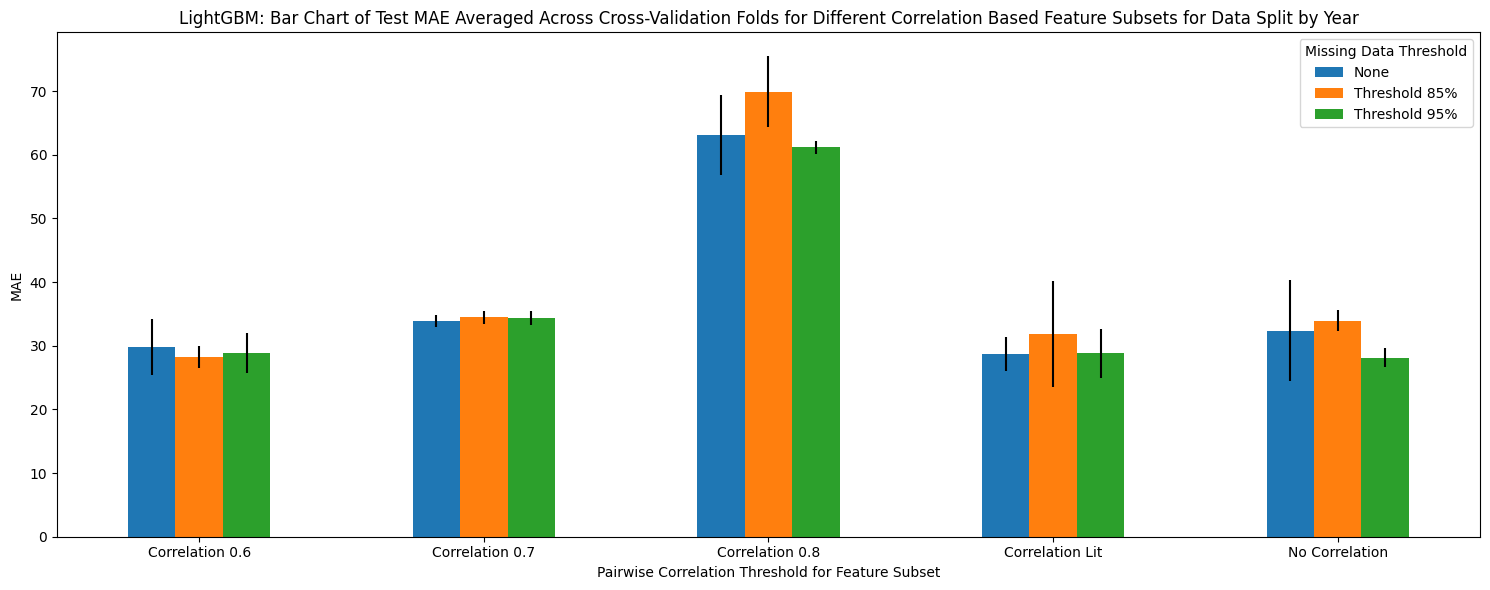

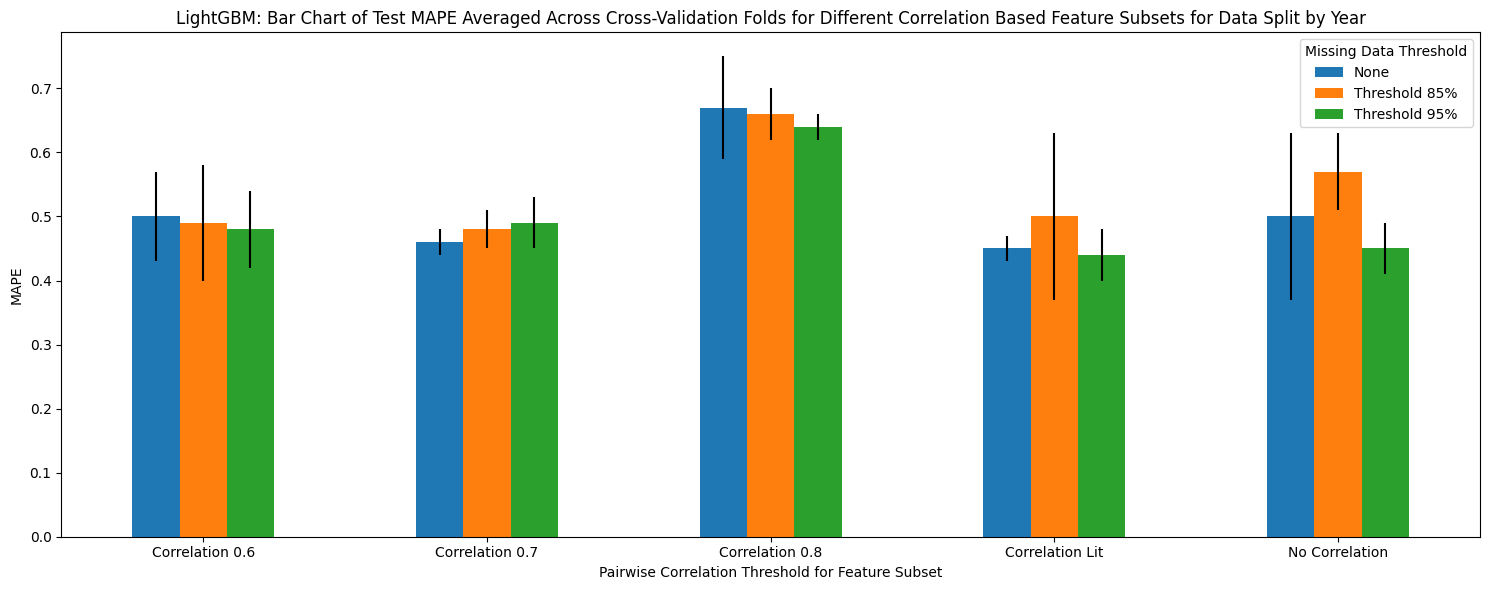

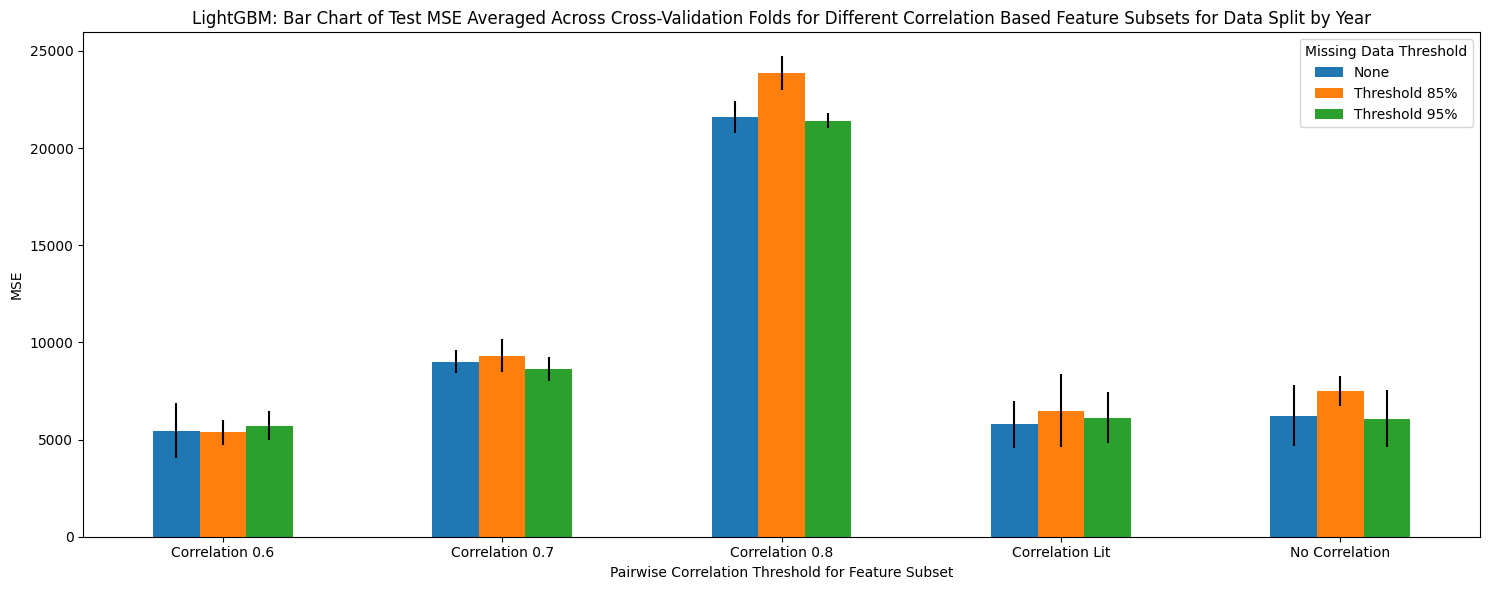

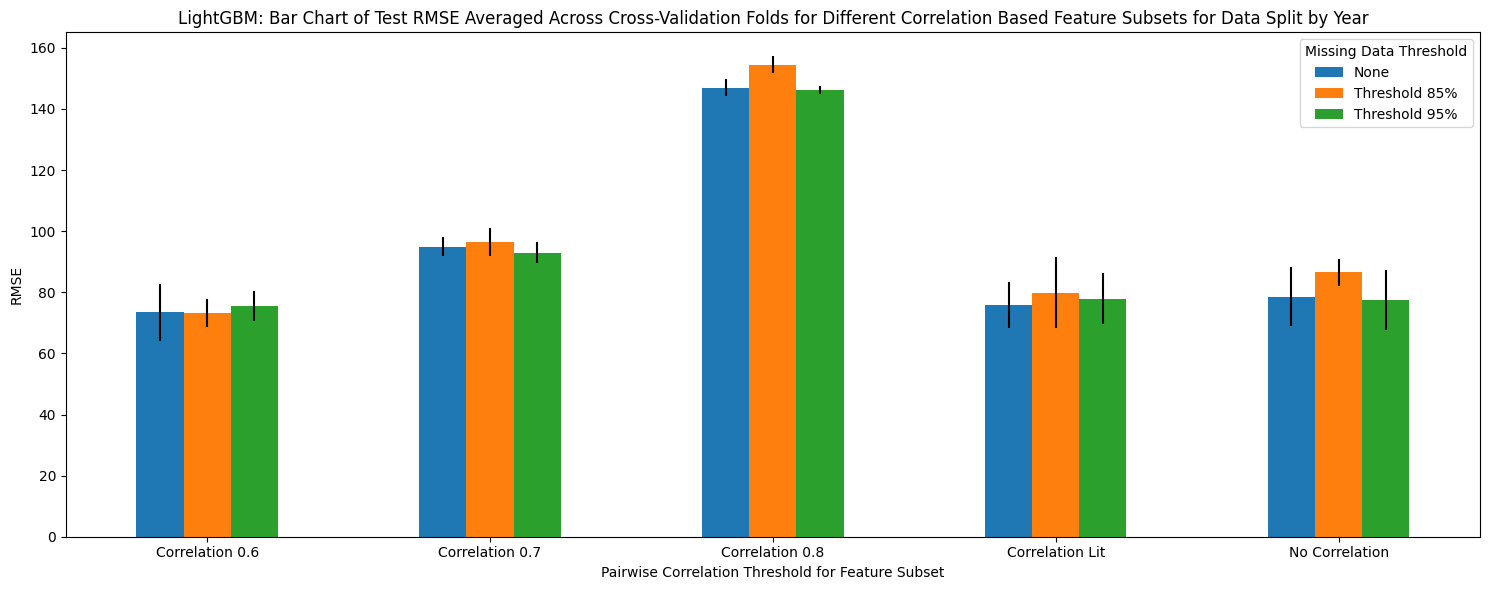

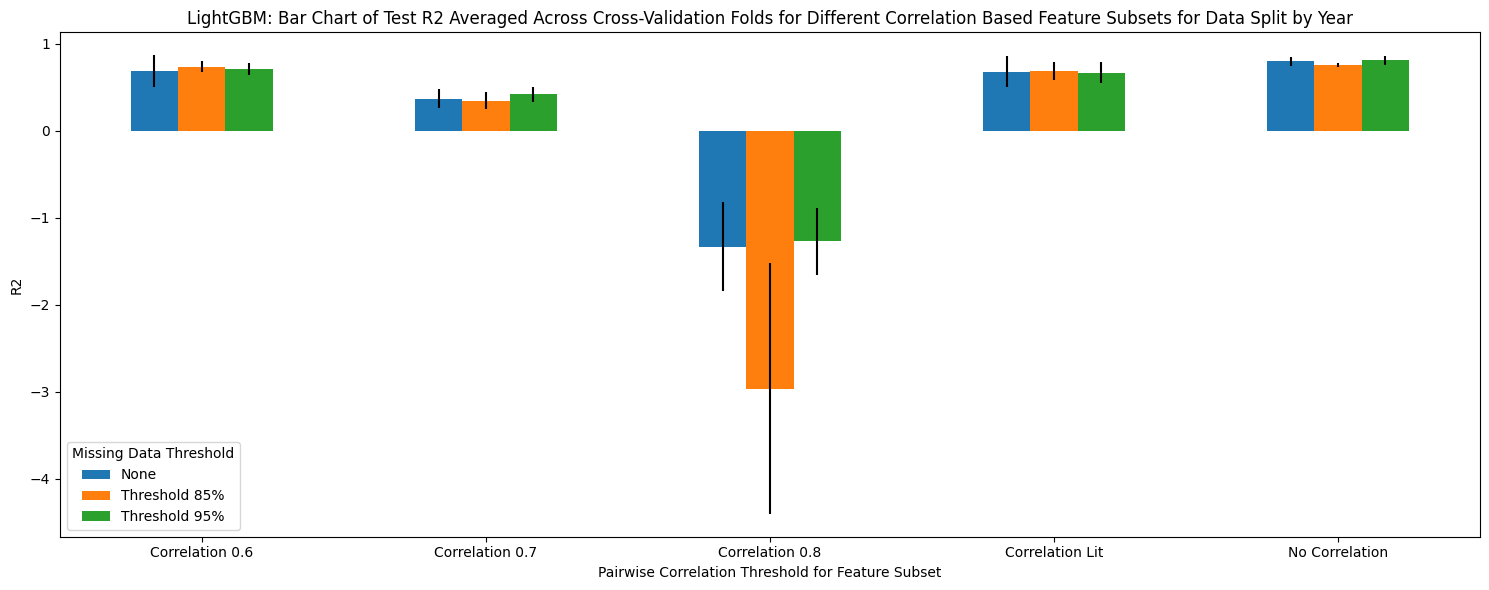

In [169]:
mean_data_lgb_year = all_data_lgb_year.astype(float)
std_data_lgb_year = all_std_data_lgb_year.astype(float)

for metric in ['MAE', 'MAPE', 'MSE', 'RMSE', 'R2']:
    mean_vals = mean_data_lgb_year[metric].unstack(level='Missing Data Threshold')
    std_vals = std_data_lgb_year[metric].unstack(level='Missing Data Threshold')
    mean_vals.plot.bar(yerr=std_vals, figsize=(15, 6), rot=0)
    plt.title("LightGBM: Bar Chart of Test " + metric + " Averaged Across Cross-Validation Folds for Different Correlation Based Feature Subsets for Data Split by Year")
    plt.xlabel("Pairwise Correlation Threshold for Feature Subset")
    plt.ylabel(metric)
    plt.tight_layout()
    plt.show()

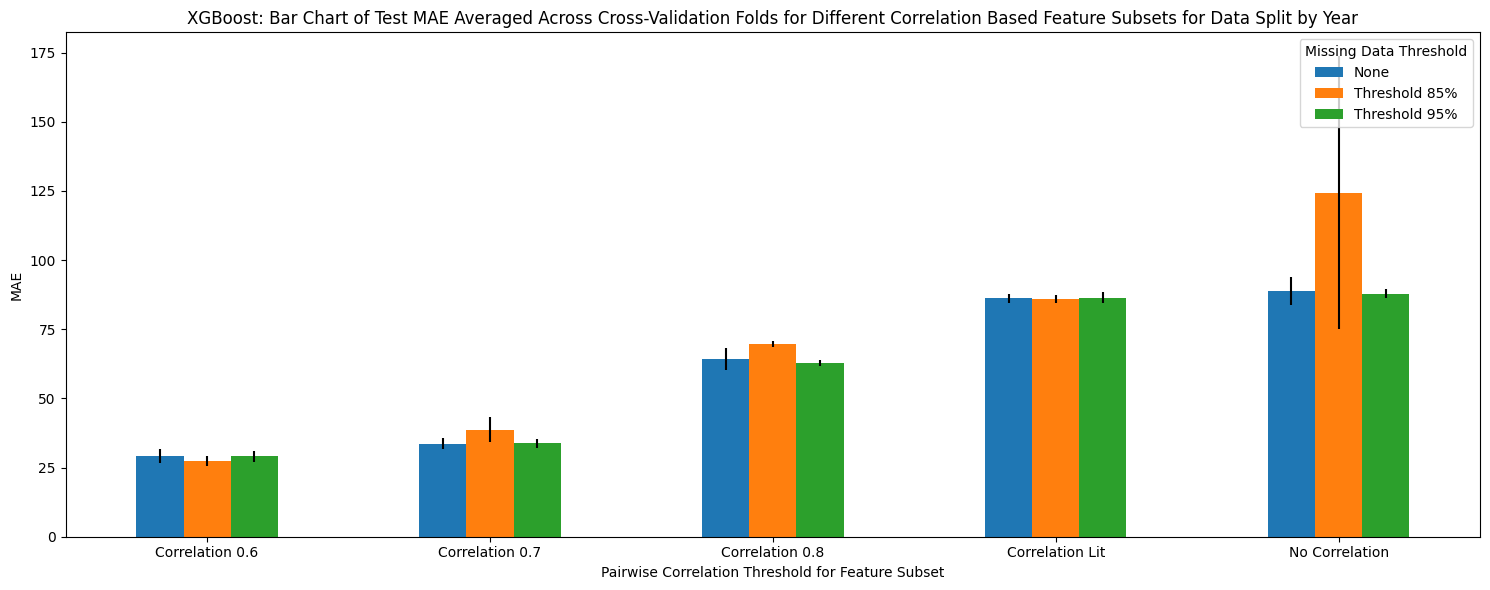

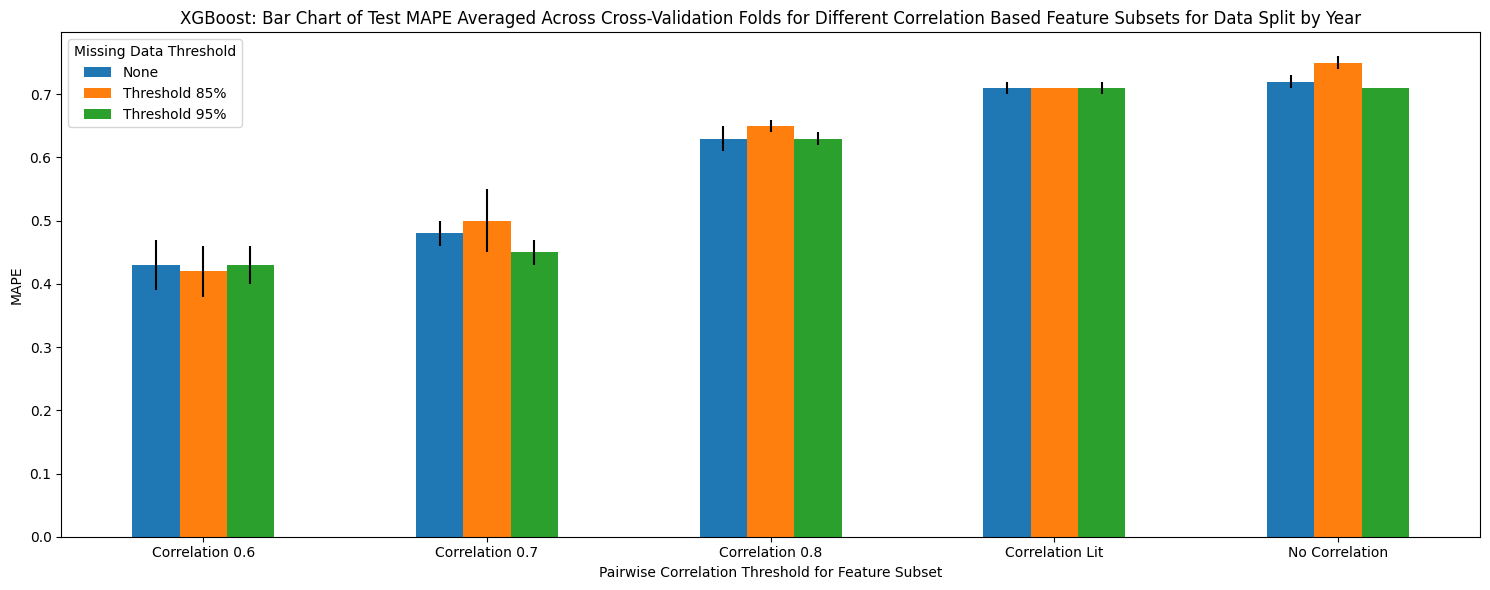

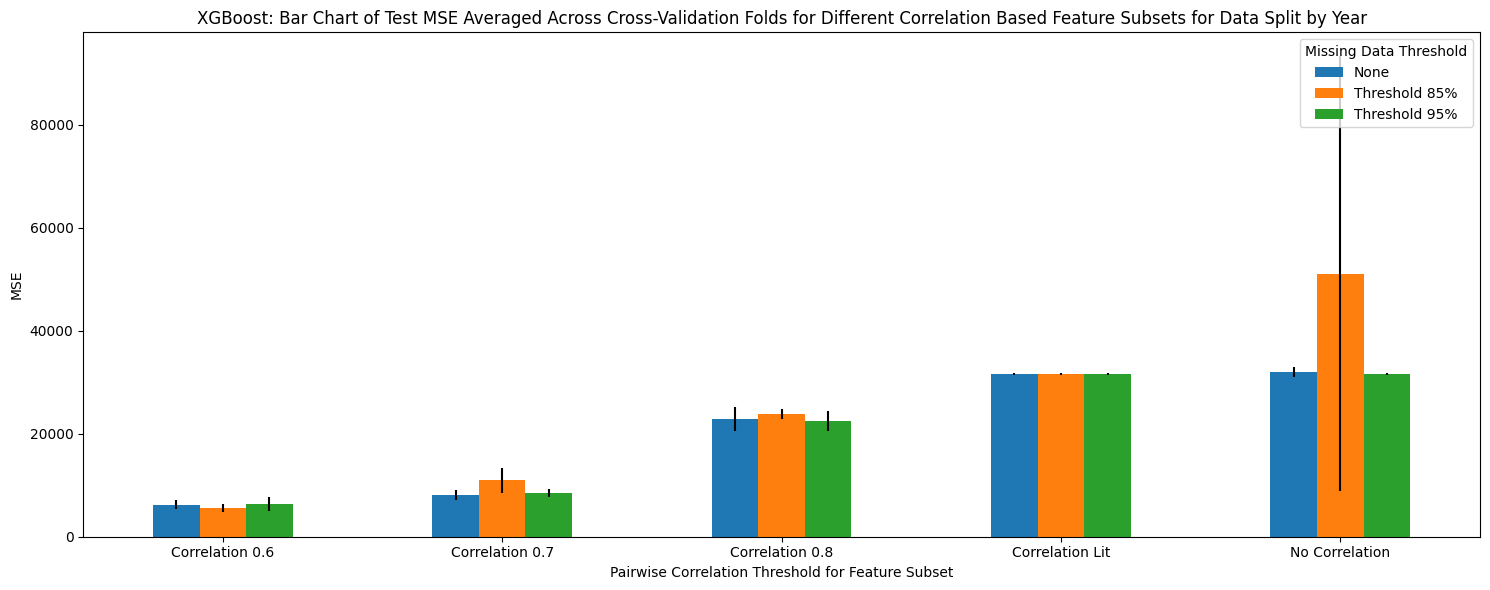

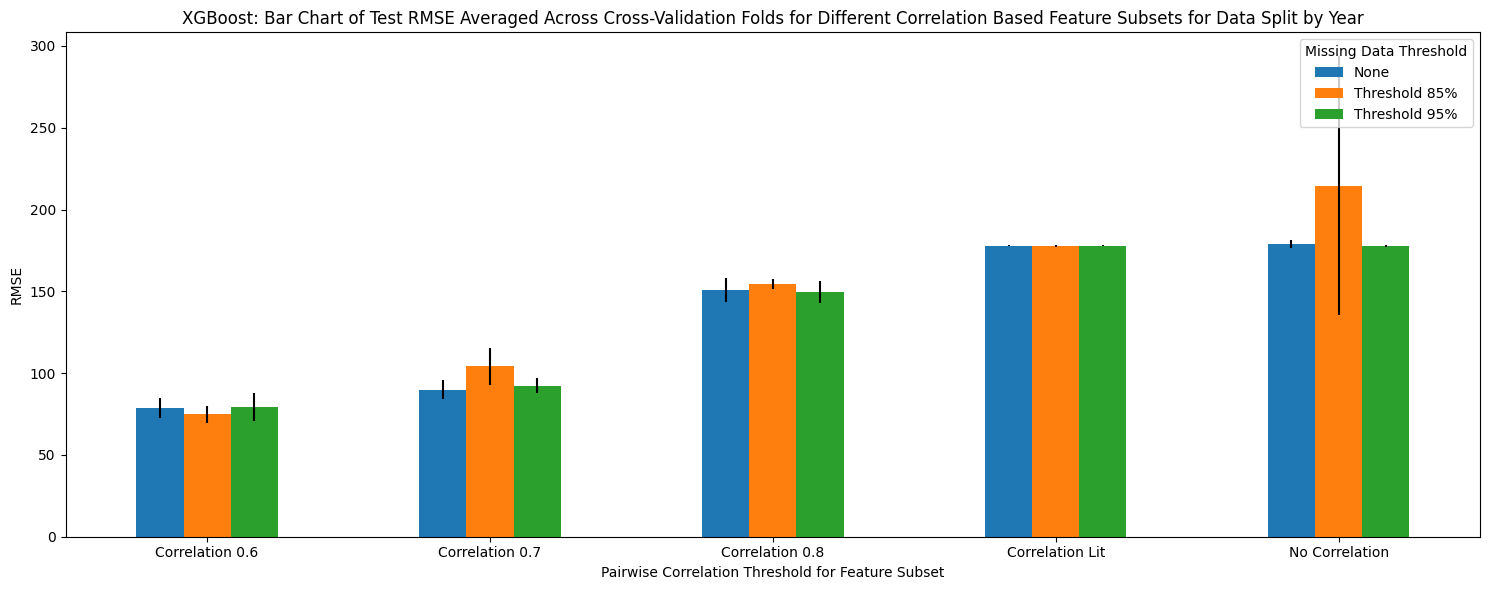

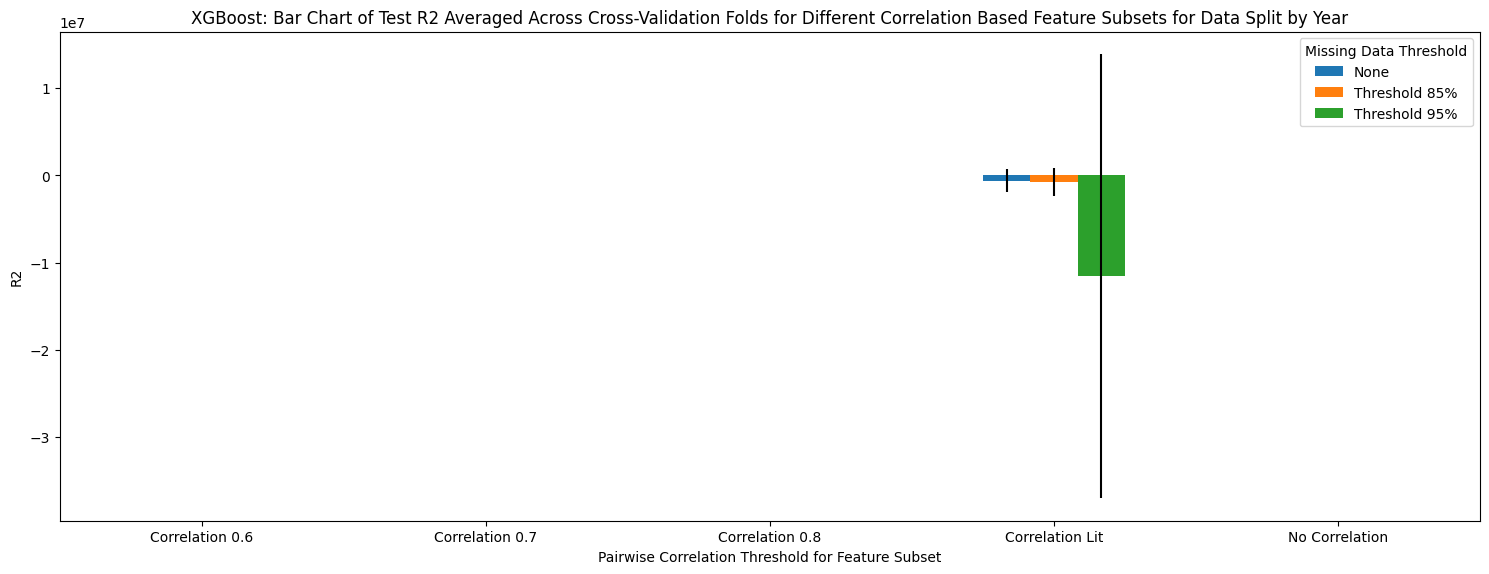

In [172]:
mean_data_xgb_year = all_data_xgb_year.astype(float)
std_data_xgb_year = all_std_data_xgb_year.astype(float)

for metric in ['MAE', 'MAPE', 'MSE', 'RMSE', 'R2']:
    mean_vals = mean_data_xgb_year[metric].unstack(level='Missing Data Threshold')
    std_vals = std_data_xgb_year[metric].unstack(level='Missing Data Threshold')
    mean_vals.plot.bar(yerr=std_vals, figsize=(15, 6), rot=0)
    plt.title("XGBoost: Bar Chart of Test " + metric + " Averaged Across Cross-Validation Folds for Different Correlation Based Feature Subsets for Data Split by Year")
    plt.xlabel("Pairwise Correlation Threshold for Feature Subset")
    plt.ylabel(metric)
    plt.tight_layout()
    plt.show()

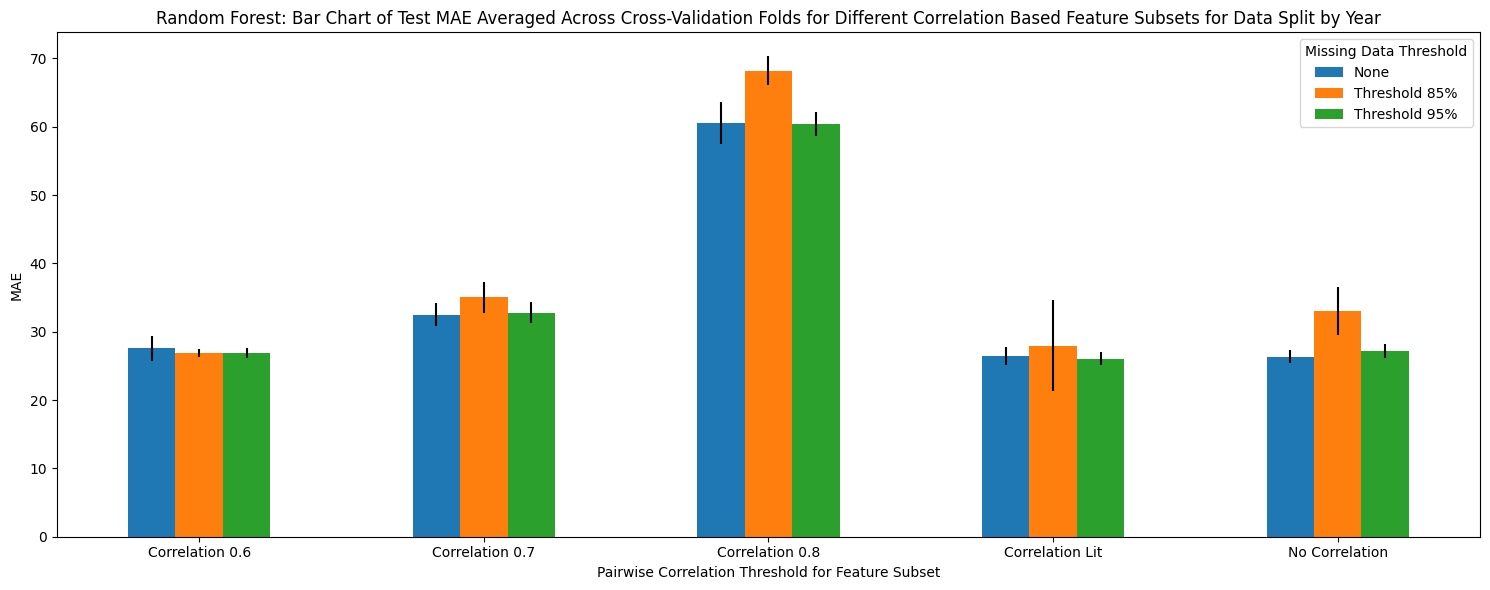

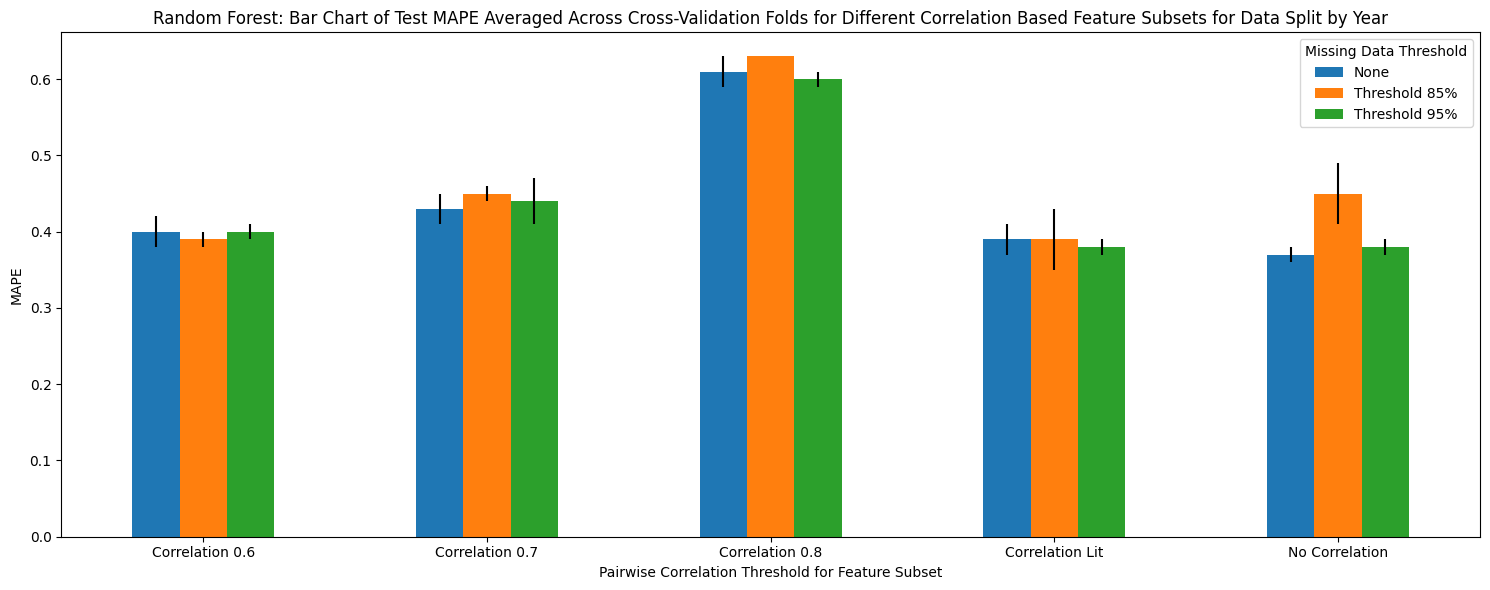

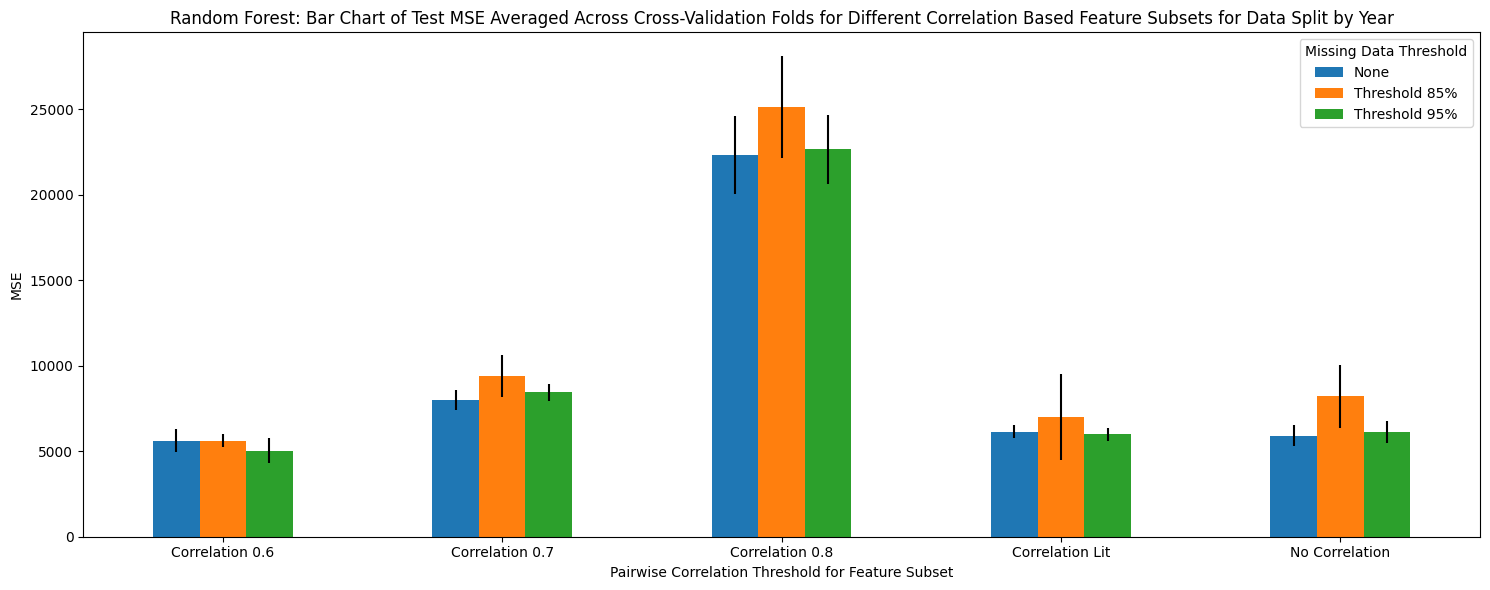

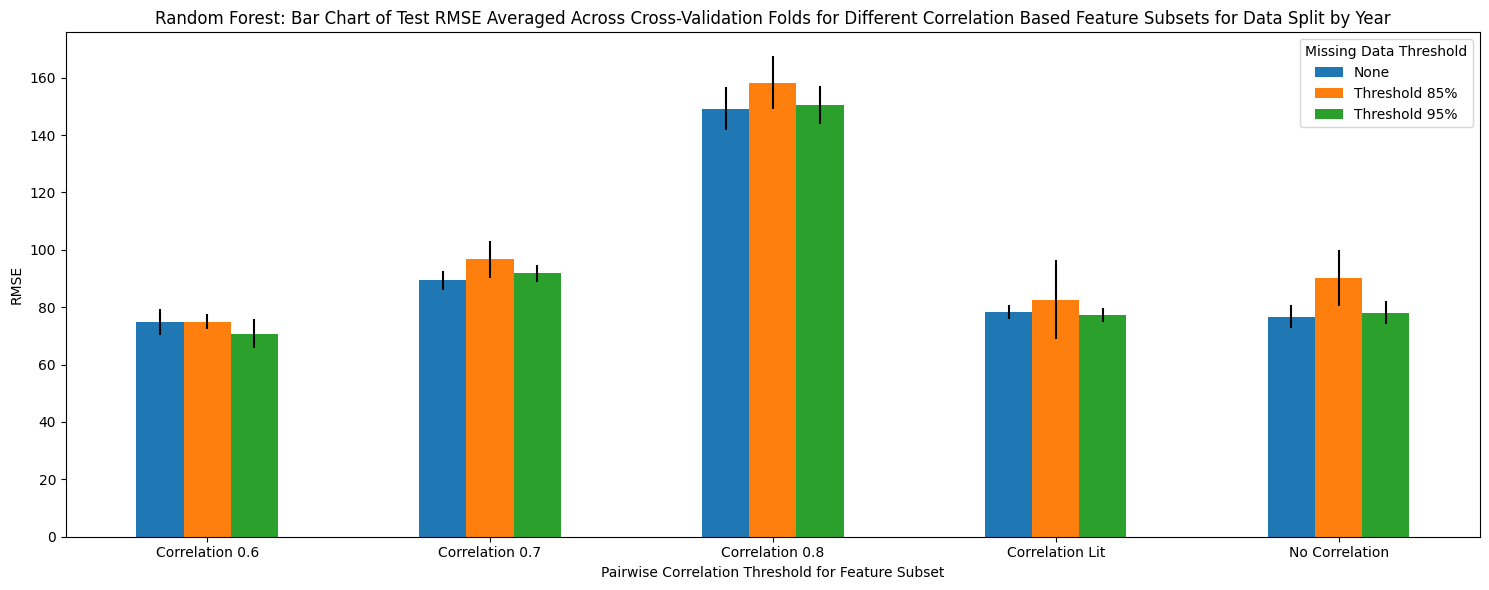

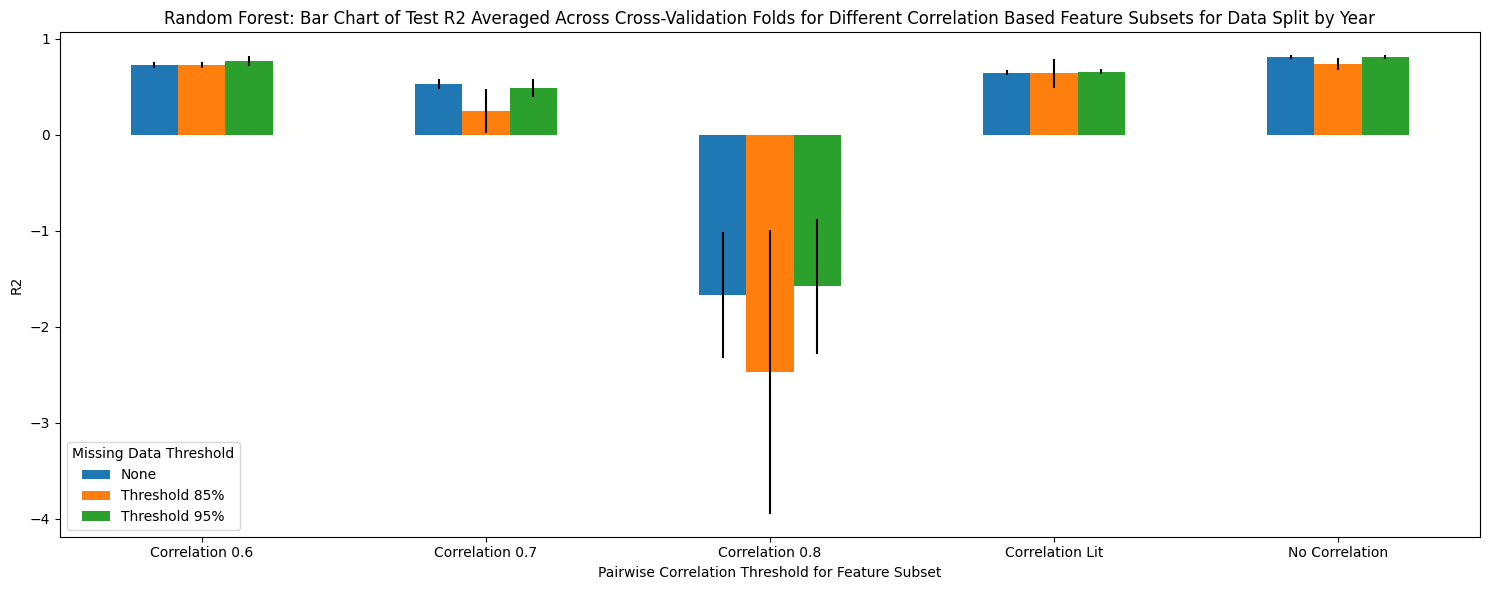

In [171]:
mean_data_rf_year = all_data_rf_year.astype(float)
std_data_rf_year = all_std_data_rf_year.astype(float)

for metric in ['MAE', 'MAPE', 'MSE', 'RMSE', 'R2']:
    mean_vals = mean_data_rf_year[metric].unstack(level='Missing Data Threshold')
    std_vals = std_data_rf_year[metric].unstack(level='Missing Data Threshold')
    mean_vals.plot.bar(yerr=std_vals, figsize=(15, 6), rot=0)
    plt.title("Random Forest: Bar Chart of Test " + metric + " Averaged Across Cross-Validation Folds for Different Correlation Based Feature Subsets for Data Split by Year")
    plt.xlabel("Pairwise Correlation Threshold for Feature Subset")
    plt.ylabel(metric)
    plt.tight_layout()
    plt.show()